<a href="https://colab.research.google.com/github/abhinaba-das/ColabFold/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [2]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'Rox_turn' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname Rox_turn_6e252
sequence EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK:EALQLAKEALYLAEKALQLAKKTGNPEALQLAKEALYLAEKALQLAK
length 376


In [3]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing hhsuite...
CPU times: user 297 ms, sys: 46 ms, total: 343 ms
Wall time: 1min 29s


In [4]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "single_sequence" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [5]:
#@markdown ### Advanced settings
model_type = "alphafold2_multimer_v2" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "6" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "512:1024" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 8 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-04-02 23:09:33,302 Running on GPU
2025-04-02 23:09:33,700 Found 5 citations for tools or databases
2025-04-02 23:09:33,700 Query 1/1: Rox_turn_6e252 (length 376)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


2025-04-02 23:09:34,249 Sequence 0 found no templates


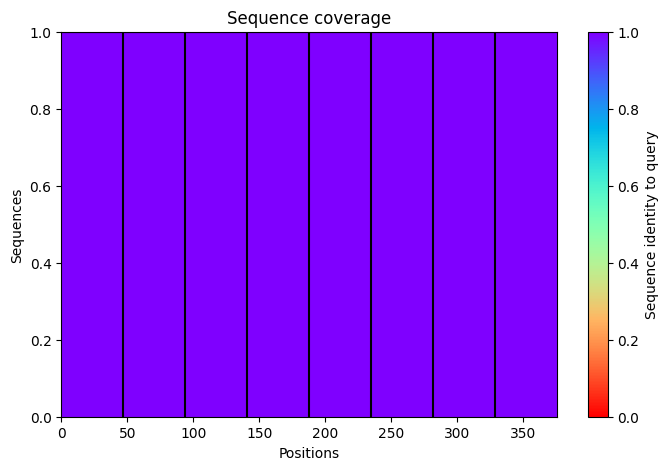

2025-04-02 23:10:32,308 alphafold2_multimer_v2_model_1_seed_000 recycle=0 pLDDT=74.2 pTM=0.296 ipTM=0.203
2025-04-02 23:10:43,734 alphafold2_multimer_v2_model_1_seed_000 recycle=1 pLDDT=71.8 pTM=0.304 ipTM=0.211 tol=14.6
2025-04-02 23:10:55,250 alphafold2_multimer_v2_model_1_seed_000 recycle=2 pLDDT=74.3 pTM=0.327 ipTM=0.237 tol=17.6
2025-04-02 23:11:06,872 alphafold2_multimer_v2_model_1_seed_000 recycle=3 pLDDT=77.2 pTM=0.381 ipTM=0.299 tol=5.24
2025-04-02 23:11:18,651 alphafold2_multimer_v2_model_1_seed_000 recycle=4 pLDDT=79 pTM=0.449 ipTM=0.376 tol=7.77
2025-04-02 23:11:30,528 alphafold2_multimer_v2_model_1_seed_000 recycle=5 pLDDT=84.9 pTM=0.604 ipTM=0.554 tol=6.37
2025-04-02 23:11:42,522 alphafold2_multimer_v2_model_1_seed_000 recycle=6 pLDDT=83.4 pTM=0.556 ipTM=0.499 tol=6.38
2025-04-02 23:11:42,524 alphafold2_multimer_v2_model_1_seed_000 took 118.3s (6 recycles)


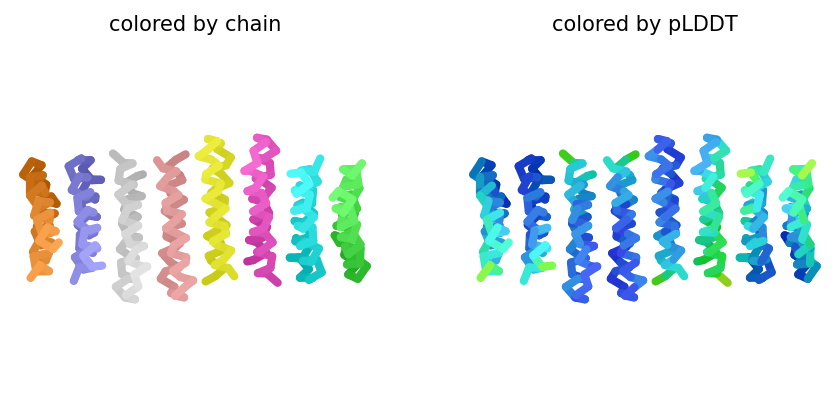

2025-04-02 23:11:55,047 alphafold2_multimer_v2_model_2_seed_000 recycle=0 pLDDT=62.1 pTM=0.265 ipTM=0.172
2025-04-02 23:12:07,346 alphafold2_multimer_v2_model_2_seed_000 recycle=1 pLDDT=59 pTM=0.259 ipTM=0.162 tol=16
2025-04-02 23:12:19,654 alphafold2_multimer_v2_model_2_seed_000 recycle=2 pLDDT=88.5 pTM=0.701 ipTM=0.665 tol=10.6
2025-04-02 23:12:31,903 alphafold2_multimer_v2_model_2_seed_000 recycle=3 pLDDT=77.6 pTM=0.354 ipTM=0.267 tol=11.7
2025-04-02 23:12:44,165 alphafold2_multimer_v2_model_2_seed_000 recycle=4 pLDDT=73.8 pTM=0.317 ipTM=0.225 tol=28.5
2025-04-02 23:12:56,265 alphafold2_multimer_v2_model_2_seed_000 recycle=5 pLDDT=77.8 pTM=0.42 ipTM=0.343 tol=19
2025-04-02 23:13:08,356 alphafold2_multimer_v2_model_2_seed_000 recycle=6 pLDDT=70.9 pTM=0.342 ipTM=0.255 tol=22.8
2025-04-02 23:13:08,357 alphafold2_multimer_v2_model_2_seed_000 took 85.5s (6 recycles)


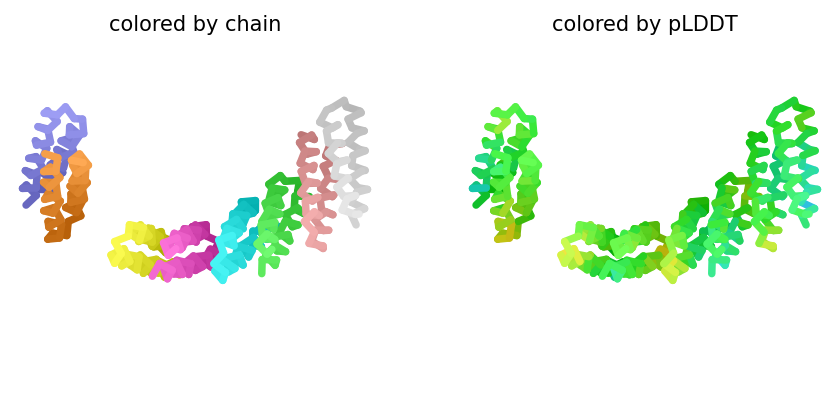

2025-04-02 23:13:20,739 alphafold2_multimer_v2_model_3_seed_000 recycle=0 pLDDT=78.4 pTM=0.513 ipTM=0.449
2025-04-02 23:13:32,920 alphafold2_multimer_v2_model_3_seed_000 recycle=1 pLDDT=92.6 pTM=0.846 ipTM=0.828 tol=22.3
2025-04-02 23:13:45,103 alphafold2_multimer_v2_model_3_seed_000 recycle=2 pLDDT=90.9 pTM=0.789 ipTM=0.763 tol=0.222
2025-04-02 23:13:57,271 alphafold2_multimer_v2_model_3_seed_000 recycle=3 pLDDT=91.9 pTM=0.821 ipTM=0.8 tol=1.74
2025-04-02 23:14:09,416 alphafold2_multimer_v2_model_3_seed_000 recycle=4 pLDDT=93.2 pTM=0.835 ipTM=0.816 tol=0.107
2025-04-02 23:14:21,562 alphafold2_multimer_v2_model_3_seed_000 recycle=5 pLDDT=92.8 pTM=0.82 ipTM=0.799 tol=0.0634
2025-04-02 23:14:33,703 alphafold2_multimer_v2_model_3_seed_000 recycle=6 pLDDT=92.5 pTM=0.812 ipTM=0.79 tol=0.0566
2025-04-02 23:14:33,704 alphafold2_multimer_v2_model_3_seed_000 took 85.1s (6 recycles)


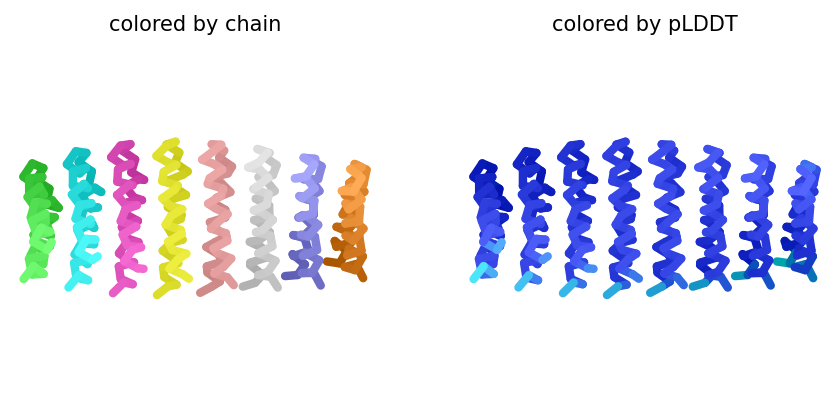

2025-04-02 23:14:46,141 alphafold2_multimer_v2_model_4_seed_000 recycle=0 pLDDT=56.6 pTM=0.2 ipTM=0.0948
2025-04-02 23:14:58,328 alphafold2_multimer_v2_model_4_seed_000 recycle=1 pLDDT=58.9 pTM=0.206 ipTM=0.0999 tol=13.1
2025-04-02 23:15:10,504 alphafold2_multimer_v2_model_4_seed_000 recycle=2 pLDDT=57.4 pTM=0.202 ipTM=0.0949 tol=3.6
2025-04-02 23:15:22,676 alphafold2_multimer_v2_model_4_seed_000 recycle=3 pLDDT=58.1 pTM=0.208 ipTM=0.102 tol=1.97
2025-04-02 23:15:34,851 alphafold2_multimer_v2_model_4_seed_000 recycle=4 pLDDT=57.5 pTM=0.201 ipTM=0.0947 tol=2.74
2025-04-02 23:15:47,015 alphafold2_multimer_v2_model_4_seed_000 recycle=5 pLDDT=64.8 pTM=0.266 ipTM=0.169 tol=8.91
2025-04-02 23:15:59,180 alphafold2_multimer_v2_model_4_seed_000 recycle=6 pLDDT=70.8 pTM=0.273 ipTM=0.177 tol=4.36
2025-04-02 23:15:59,181 alphafold2_multimer_v2_model_4_seed_000 took 85.2s (6 recycles)


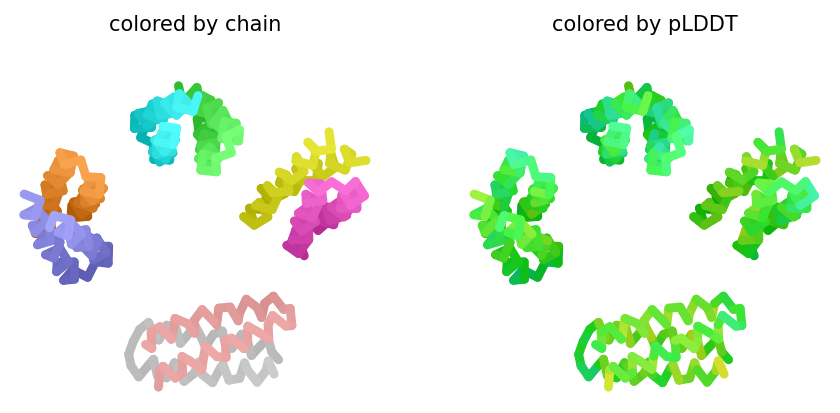

2025-04-02 23:16:11,648 alphafold2_multimer_v2_model_5_seed_000 recycle=0 pLDDT=60 pTM=0.253 ipTM=0.154
2025-04-02 23:16:23,847 alphafold2_multimer_v2_model_5_seed_000 recycle=1 pLDDT=59.2 pTM=0.193 ipTM=0.0858 tol=12.9
2025-04-02 23:16:36,043 alphafold2_multimer_v2_model_5_seed_000 recycle=2 pLDDT=57.7 pTM=0.195 ipTM=0.0875 tol=17.7
2025-04-02 23:16:48,267 alphafold2_multimer_v2_model_5_seed_000 recycle=3 pLDDT=57.8 pTM=0.204 ipTM=0.0968 tol=9.03
2025-04-02 23:17:00,461 alphafold2_multimer_v2_model_5_seed_000 recycle=4 pLDDT=57.9 pTM=0.208 ipTM=0.101 tol=2.92
2025-04-02 23:17:12,667 alphafold2_multimer_v2_model_5_seed_000 recycle=5 pLDDT=56.8 pTM=0.207 ipTM=0.102 tol=6.99
2025-04-02 23:17:24,861 alphafold2_multimer_v2_model_5_seed_000 recycle=6 pLDDT=55.2 pTM=0.209 ipTM=0.104 tol=13.9
2025-04-02 23:17:24,862 alphafold2_multimer_v2_model_5_seed_000 took 85.4s (6 recycles)


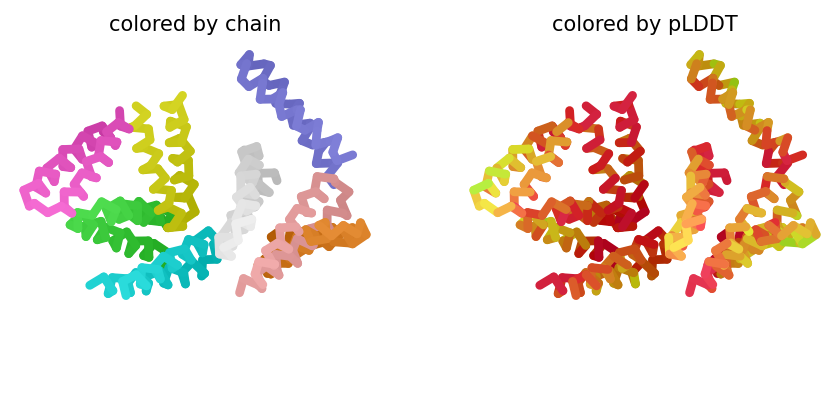

2025-04-02 23:17:37,290 alphafold2_multimer_v2_model_1_seed_001 recycle=0 pLDDT=75.6 pTM=0.302 ipTM=0.209
2025-04-02 23:17:49,457 alphafold2_multimer_v2_model_1_seed_001 recycle=1 pLDDT=73.4 pTM=0.306 ipTM=0.214 tol=14
2025-04-02 23:18:01,641 alphafold2_multimer_v2_model_1_seed_001 recycle=2 pLDDT=75.1 pTM=0.327 ipTM=0.237 tol=11.3
2025-04-02 23:18:13,838 alphafold2_multimer_v2_model_1_seed_001 recycle=3 pLDDT=74.5 pTM=0.357 ipTM=0.271 tol=4.71
2025-04-02 23:18:26,011 alphafold2_multimer_v2_model_1_seed_001 recycle=4 pLDDT=73.8 pTM=0.379 ipTM=0.297 tol=1.15
2025-04-02 23:18:38,170 alphafold2_multimer_v2_model_1_seed_001 recycle=5 pLDDT=73.6 pTM=0.421 ipTM=0.345 tol=4.91
2025-04-02 23:18:50,318 alphafold2_multimer_v2_model_1_seed_001 recycle=6 pLDDT=73.1 pTM=0.322 ipTM=0.232 tol=23.6
2025-04-02 23:18:50,319 alphafold2_multimer_v2_model_1_seed_001 took 85.2s (6 recycles)


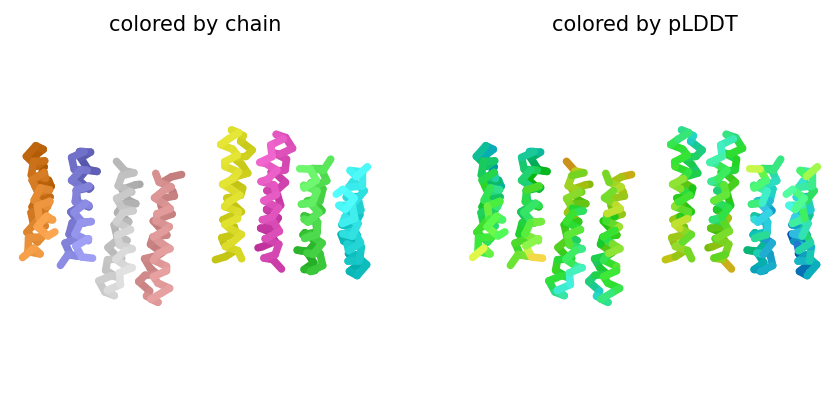

2025-04-02 23:19:02,797 alphafold2_multimer_v2_model_2_seed_001 recycle=0 pLDDT=56.8 pTM=0.229 ipTM=0.133
2025-04-02 23:19:14,941 alphafold2_multimer_v2_model_2_seed_001 recycle=1 pLDDT=54.5 pTM=0.202 ipTM=0.0982 tol=18.9
2025-04-02 23:19:27,091 alphafold2_multimer_v2_model_2_seed_001 recycle=2 pLDDT=53.8 pTM=0.199 ipTM=0.0948 tol=9.2
2025-04-02 23:19:39,252 alphafold2_multimer_v2_model_2_seed_001 recycle=3 pLDDT=54.8 pTM=0.202 ipTM=0.0956 tol=7.83
2025-04-02 23:19:51,435 alphafold2_multimer_v2_model_2_seed_001 recycle=4 pLDDT=54.3 pTM=0.201 ipTM=0.0955 tol=8.84
2025-04-02 23:20:03,600 alphafold2_multimer_v2_model_2_seed_001 recycle=5 pLDDT=54.3 pTM=0.209 ipTM=0.106 tol=8.39
2025-04-02 23:20:15,761 alphafold2_multimer_v2_model_2_seed_001 recycle=6 pLDDT=54.2 pTM=0.204 ipTM=0.0995 tol=6.25
2025-04-02 23:20:15,761 alphafold2_multimer_v2_model_2_seed_001 took 85.2s (6 recycles)


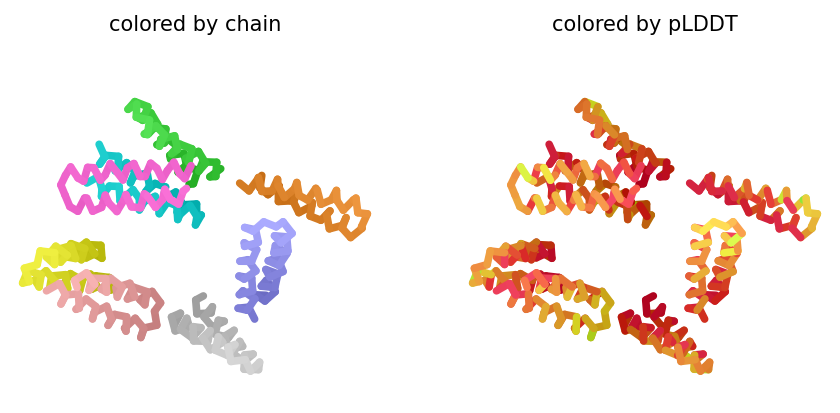

2025-04-02 23:20:28,191 alphafold2_multimer_v2_model_3_seed_001 recycle=0 pLDDT=79.4 pTM=0.543 ipTM=0.484
2025-04-02 23:20:40,331 alphafold2_multimer_v2_model_3_seed_001 recycle=1 pLDDT=92.8 pTM=0.844 ipTM=0.826 tol=22
2025-04-02 23:20:52,458 alphafold2_multimer_v2_model_3_seed_001 recycle=2 pLDDT=89.6 pTM=0.779 ipTM=0.752 tol=0.29
2025-04-02 23:21:04,607 alphafold2_multimer_v2_model_3_seed_001 recycle=3 pLDDT=92.6 pTM=0.833 ipTM=0.813 tol=1.75
2025-04-02 23:21:16,752 alphafold2_multimer_v2_model_3_seed_001 recycle=4 pLDDT=93.2 pTM=0.835 ipTM=0.815 tol=0.0815
2025-04-02 23:21:29,015 alphafold2_multimer_v2_model_3_seed_001 recycle=5 pLDDT=92.9 pTM=0.824 ipTM=0.803 tol=0.0376
2025-04-02 23:21:41,158 alphafold2_multimer_v2_model_3_seed_001 recycle=6 pLDDT=92.5 pTM=0.813 ipTM=0.791 tol=0.0374
2025-04-02 23:21:41,159 alphafold2_multimer_v2_model_3_seed_001 took 85.1s (6 recycles)


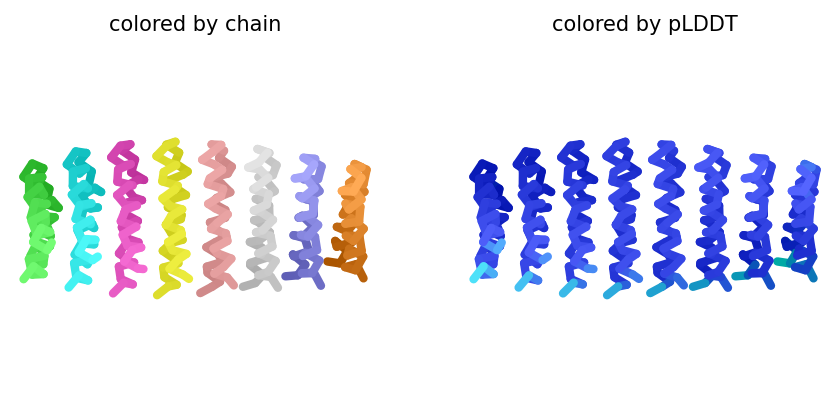

2025-04-02 23:21:53,613 alphafold2_multimer_v2_model_4_seed_001 recycle=0 pLDDT=58.8 pTM=0.224 ipTM=0.122
2025-04-02 23:22:05,814 alphafold2_multimer_v2_model_4_seed_001 recycle=1 pLDDT=57.9 pTM=0.192 ipTM=0.0834 tol=17.4
2025-04-02 23:22:18,019 alphafold2_multimer_v2_model_4_seed_001 recycle=2 pLDDT=56.4 pTM=0.192 ipTM=0.0836 tol=13.1
2025-04-02 23:22:30,187 alphafold2_multimer_v2_model_4_seed_001 recycle=3 pLDDT=75.2 pTM=0.295 ipTM=0.2 tol=14.1
2025-04-02 23:22:42,380 alphafold2_multimer_v2_model_4_seed_001 recycle=4 pLDDT=78.6 pTM=0.278 ipTM=0.181 tol=5.94
2025-04-02 23:22:54,571 alphafold2_multimer_v2_model_4_seed_001 recycle=5 pLDDT=78.8 pTM=0.287 ipTM=0.191 tol=4.54
2025-04-02 23:23:06,758 alphafold2_multimer_v2_model_4_seed_001 recycle=6 pLDDT=79.4 pTM=0.277 ipTM=0.18 tol=5.34
2025-04-02 23:23:06,758 alphafold2_multimer_v2_model_4_seed_001 took 85.3s (6 recycles)


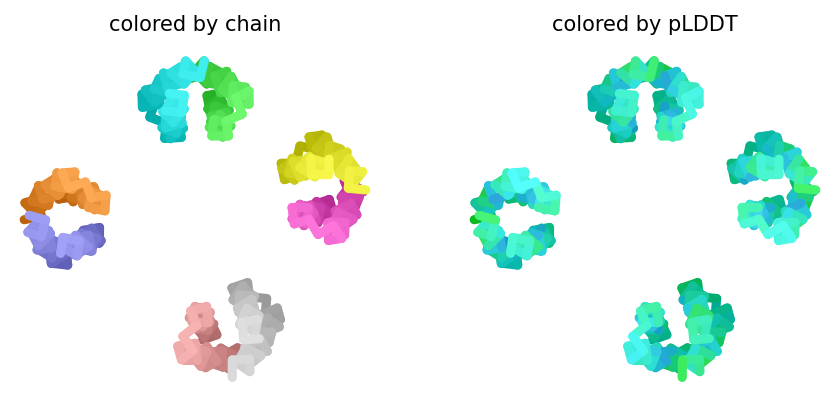

2025-04-02 23:23:19,521 alphafold2_multimer_v2_model_5_seed_001 recycle=0 pLDDT=60.9 pTM=0.251 ipTM=0.153
2025-04-02 23:23:31,896 alphafold2_multimer_v2_model_5_seed_001 recycle=1 pLDDT=59.6 pTM=0.192 ipTM=0.0848 tol=15.5
2025-04-02 23:23:44,250 alphafold2_multimer_v2_model_5_seed_001 recycle=2 pLDDT=58.2 pTM=0.195 ipTM=0.087 tol=13.1
2025-04-02 23:23:56,585 alphafold2_multimer_v2_model_5_seed_001 recycle=3 pLDDT=55.6 pTM=0.209 ipTM=0.102 tol=15.9
2025-04-02 23:24:08,787 alphafold2_multimer_v2_model_5_seed_001 recycle=4 pLDDT=57.9 pTM=0.2 ipTM=0.0933 tol=11.6
2025-04-02 23:24:20,979 alphafold2_multimer_v2_model_5_seed_001 recycle=5 pLDDT=56.1 pTM=0.203 ipTM=0.0978 tol=8.2
2025-04-02 23:24:33,160 alphafold2_multimer_v2_model_5_seed_001 recycle=6 pLDDT=58.6 pTM=0.227 ipTM=0.126 tol=12.1
2025-04-02 23:24:33,161 alphafold2_multimer_v2_model_5_seed_001 took 86.0s (6 recycles)


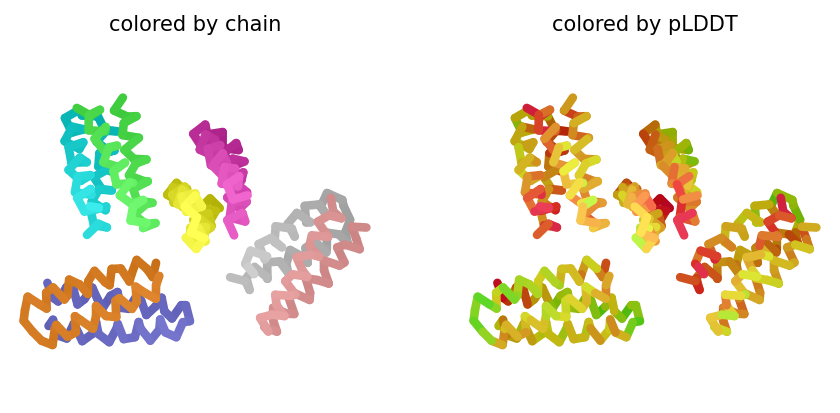

2025-04-02 23:24:45,606 alphafold2_multimer_v2_model_1_seed_002 recycle=0 pLDDT=75.3 pTM=0.295 ipTM=0.2
2025-04-02 23:24:57,771 alphafold2_multimer_v2_model_1_seed_002 recycle=1 pLDDT=74.3 pTM=0.314 ipTM=0.223 tol=19.1
2025-04-02 23:25:09,928 alphafold2_multimer_v2_model_1_seed_002 recycle=2 pLDDT=77.8 pTM=0.375 ipTM=0.291 tol=3.69
2025-04-02 23:25:22,096 alphafold2_multimer_v2_model_1_seed_002 recycle=3 pLDDT=77.2 pTM=0.386 ipTM=0.306 tol=4.55
2025-04-02 23:25:34,254 alphafold2_multimer_v2_model_1_seed_002 recycle=4 pLDDT=77.2 pTM=0.386 ipTM=0.305 tol=0.462
2025-04-02 23:25:46,422 alphafold2_multimer_v2_model_1_seed_002 recycle=5 pLDDT=83.3 pTM=0.517 ipTM=0.454 tol=1.28
2025-04-02 23:25:58,571 alphafold2_multimer_v2_model_1_seed_002 recycle=6 pLDDT=80.2 pTM=0.476 ipTM=0.406 tol=6.49
2025-04-02 23:25:58,571 alphafold2_multimer_v2_model_1_seed_002 took 85.1s (6 recycles)


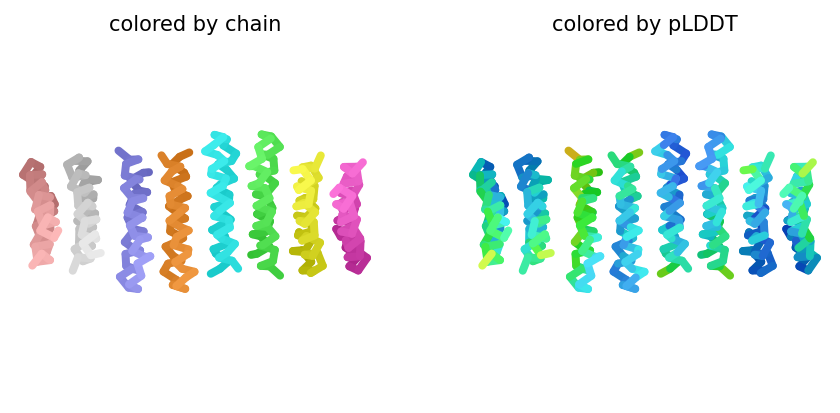

2025-04-02 23:26:11,088 alphafold2_multimer_v2_model_2_seed_002 recycle=0 pLDDT=53.4 pTM=0.207 ipTM=0.106
2025-04-02 23:26:23,259 alphafold2_multimer_v2_model_2_seed_002 recycle=1 pLDDT=54.6 pTM=0.195 ipTM=0.0906 tol=16.2
2025-04-02 23:26:35,456 alphafold2_multimer_v2_model_2_seed_002 recycle=2 pLDDT=54.2 pTM=0.197 ipTM=0.092 tol=11.3
2025-04-02 23:26:47,657 alphafold2_multimer_v2_model_2_seed_002 recycle=3 pLDDT=54.2 pTM=0.195 ipTM=0.0905 tol=6.19
2025-04-02 23:26:59,833 alphafold2_multimer_v2_model_2_seed_002 recycle=4 pLDDT=54.8 pTM=0.194 ipTM=0.0901 tol=6.8
2025-04-02 23:27:12,004 alphafold2_multimer_v2_model_2_seed_002 recycle=5 pLDDT=55 pTM=0.198 ipTM=0.0928 tol=4.61
2025-04-02 23:27:24,154 alphafold2_multimer_v2_model_2_seed_002 recycle=6 pLDDT=54.9 pTM=0.197 ipTM=0.091 tol=4.86
2025-04-02 23:27:24,155 alphafold2_multimer_v2_model_2_seed_002 took 85.3s (6 recycles)


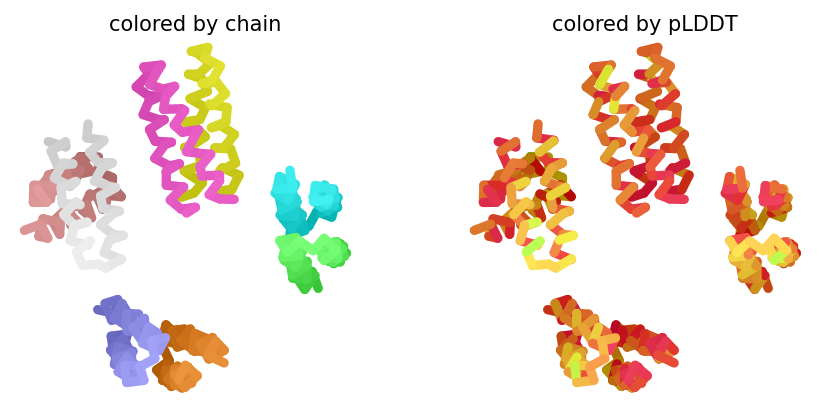

2025-04-02 23:27:36,565 alphafold2_multimer_v2_model_3_seed_002 recycle=0 pLDDT=82.1 pTM=0.624 ipTM=0.576
2025-04-02 23:27:48,688 alphafold2_multimer_v2_model_3_seed_002 recycle=1 pLDDT=92.7 pTM=0.846 ipTM=0.828 tol=5.81
2025-04-02 23:28:00,797 alphafold2_multimer_v2_model_3_seed_002 recycle=2 pLDDT=91.1 pTM=0.792 ipTM=0.766 tol=0.18
2025-04-02 23:28:12,906 alphafold2_multimer_v2_model_3_seed_002 recycle=3 pLDDT=90.6 pTM=0.782 ipTM=0.756 tol=0.0933
2025-04-02 23:28:25,041 alphafold2_multimer_v2_model_3_seed_002 recycle=4 pLDDT=90.1 pTM=0.771 ipTM=0.743 tol=0.0723
2025-04-02 23:28:37,159 alphafold2_multimer_v2_model_3_seed_002 recycle=5 pLDDT=89.6 pTM=0.763 ipTM=0.735 tol=0.0272
2025-04-02 23:28:49,284 alphafold2_multimer_v2_model_3_seed_002 recycle=6 pLDDT=91.8 pTM=0.812 ipTM=0.79 tol=1.71
2025-04-02 23:28:49,285 alphafold2_multimer_v2_model_3_seed_002 took 84.8s (6 recycles)


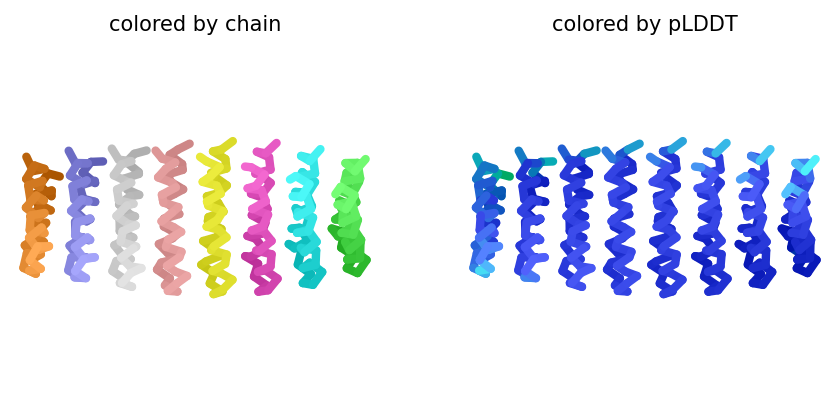

2025-04-02 23:29:01,736 alphafold2_multimer_v2_model_4_seed_002 recycle=0 pLDDT=57.2 pTM=0.206 ipTM=0.102
2025-04-02 23:29:13,903 alphafold2_multimer_v2_model_4_seed_002 recycle=1 pLDDT=57.8 pTM=0.192 ipTM=0.0841 tol=14.1
2025-04-02 23:29:26,087 alphafold2_multimer_v2_model_4_seed_002 recycle=2 pLDDT=57.8 pTM=0.19 ipTM=0.0819 tol=9.74
2025-04-02 23:29:38,254 alphafold2_multimer_v2_model_4_seed_002 recycle=3 pLDDT=72.2 pTM=0.286 ipTM=0.191 tol=14.5
2025-04-02 23:29:50,424 alphafold2_multimer_v2_model_4_seed_002 recycle=4 pLDDT=77.2 pTM=0.28 ipTM=0.183 tol=3.34
2025-04-02 23:30:02,580 alphafold2_multimer_v2_model_4_seed_002 recycle=5 pLDDT=77.8 pTM=0.285 ipTM=0.189 tol=4.23
2025-04-02 23:30:14,733 alphafold2_multimer_v2_model_4_seed_002 recycle=6 pLDDT=77.4 pTM=0.278 ipTM=0.181 tol=10.7
2025-04-02 23:30:14,734 alphafold2_multimer_v2_model_4_seed_002 took 85.1s (6 recycles)


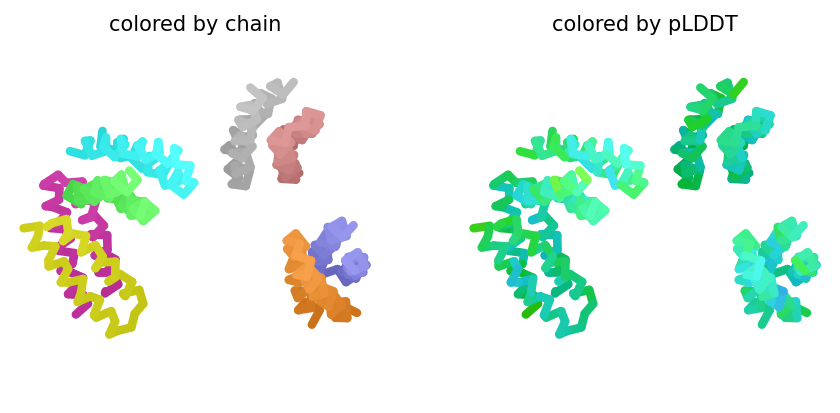

2025-04-02 23:30:27,163 alphafold2_multimer_v2_model_5_seed_002 recycle=0 pLDDT=59 pTM=0.246 ipTM=0.146
2025-04-02 23:30:39,342 alphafold2_multimer_v2_model_5_seed_002 recycle=1 pLDDT=57.2 pTM=0.21 ipTM=0.107 tol=16.2
2025-04-02 23:30:51,521 alphafold2_multimer_v2_model_5_seed_002 recycle=2 pLDDT=58 pTM=0.207 ipTM=0.102 tol=18.1
2025-04-02 23:31:03,701 alphafold2_multimer_v2_model_5_seed_002 recycle=3 pLDDT=57.2 pTM=0.201 ipTM=0.0934 tol=10.8
2025-04-02 23:31:15,877 alphafold2_multimer_v2_model_5_seed_002 recycle=4 pLDDT=57.5 pTM=0.202 ipTM=0.0959 tol=8.85
2025-04-02 23:31:28,052 alphafold2_multimer_v2_model_5_seed_002 recycle=5 pLDDT=57.7 pTM=0.196 ipTM=0.0881 tol=16.5
2025-04-02 23:31:40,214 alphafold2_multimer_v2_model_5_seed_002 recycle=6 pLDDT=56.4 pTM=0.201 ipTM=0.0946 tol=18.7
2025-04-02 23:31:40,215 alphafold2_multimer_v2_model_5_seed_002 took 85.2s (6 recycles)


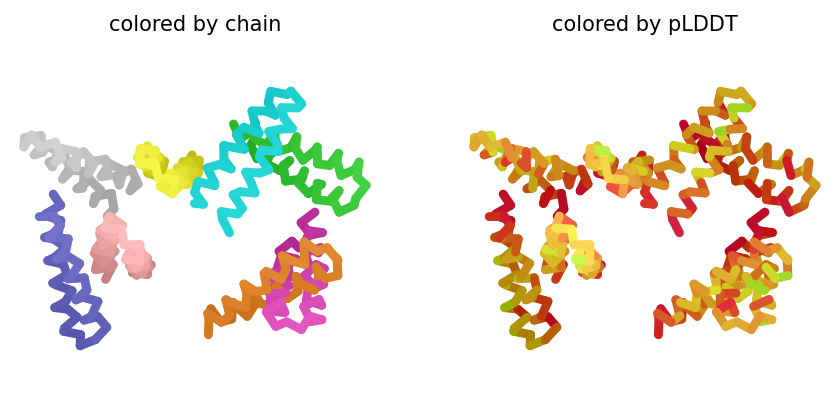

2025-04-02 23:31:52,669 alphafold2_multimer_v2_model_1_seed_003 recycle=0 pLDDT=74.9 pTM=0.294 ipTM=0.2
2025-04-02 23:32:04,831 alphafold2_multimer_v2_model_1_seed_003 recycle=1 pLDDT=74 pTM=0.317 ipTM=0.226 tol=18.9
2025-04-02 23:32:16,994 alphafold2_multimer_v2_model_1_seed_003 recycle=2 pLDDT=78 pTM=0.396 ipTM=0.315 tol=4.21
2025-04-02 23:32:29,165 alphafold2_multimer_v2_model_1_seed_003 recycle=3 pLDDT=68.2 pTM=0.365 ipTM=0.283 tol=11.7
2025-04-02 23:32:41,330 alphafold2_multimer_v2_model_1_seed_003 recycle=4 pLDDT=78.8 pTM=0.382 ipTM=0.3 tol=12.1
2025-04-02 23:32:53,473 alphafold2_multimer_v2_model_1_seed_003 recycle=5 pLDDT=79.4 pTM=0.432 ipTM=0.357 tol=7.93
2025-04-02 23:33:05,606 alphafold2_multimer_v2_model_1_seed_003 recycle=6 pLDDT=81.1 pTM=0.479 ipTM=0.41 tol=1.05
2025-04-02 23:33:05,607 alphafold2_multimer_v2_model_1_seed_003 took 85.1s (6 recycles)


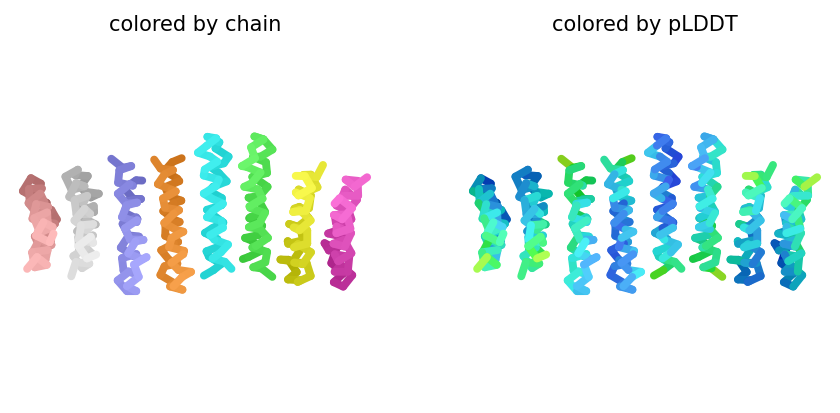

2025-04-02 23:33:18,106 alphafold2_multimer_v2_model_2_seed_003 recycle=0 pLDDT=55 pTM=0.219 ipTM=0.12
2025-04-02 23:33:30,265 alphafold2_multimer_v2_model_2_seed_003 recycle=1 pLDDT=54.7 pTM=0.199 ipTM=0.0939 tol=19.4
2025-04-02 23:33:42,419 alphafold2_multimer_v2_model_2_seed_003 recycle=2 pLDDT=54.7 pTM=0.2 ipTM=0.0948 tol=11.3
2025-04-02 23:33:54,562 alphafold2_multimer_v2_model_2_seed_003 recycle=3 pLDDT=54.2 pTM=0.194 ipTM=0.0884 tol=8.49
2025-04-02 23:34:06,717 alphafold2_multimer_v2_model_2_seed_003 recycle=4 pLDDT=54.1 pTM=0.199 ipTM=0.0942 tol=5.79
2025-04-02 23:34:18,858 alphafold2_multimer_v2_model_2_seed_003 recycle=5 pLDDT=54.5 pTM=0.211 ipTM=0.107 tol=5.55
2025-04-02 23:34:31,012 alphafold2_multimer_v2_model_2_seed_003 recycle=6 pLDDT=54.1 pTM=0.204 ipTM=0.0999 tol=8.72
2025-04-02 23:34:31,013 alphafold2_multimer_v2_model_2_seed_003 took 85.1s (6 recycles)


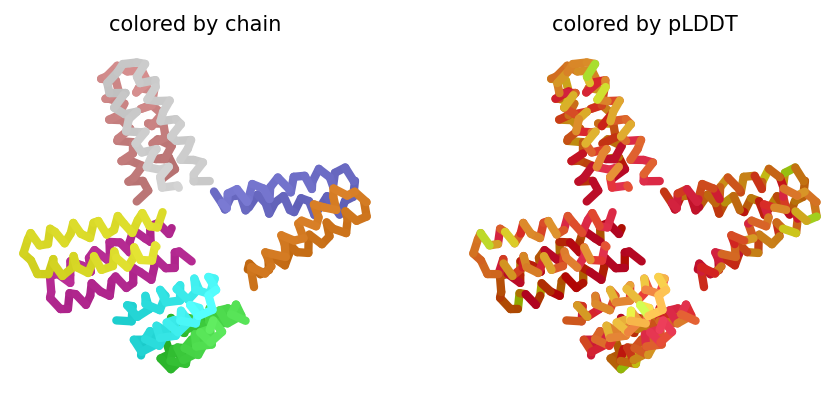

2025-04-02 23:34:43,474 alphafold2_multimer_v2_model_3_seed_003 recycle=0 pLDDT=82.1 pTM=0.617 ipTM=0.568
2025-04-02 23:34:55,593 alphafold2_multimer_v2_model_3_seed_003 recycle=1 pLDDT=93.1 pTM=0.848 ipTM=0.83 tol=7.27
2025-04-02 23:35:07,719 alphafold2_multimer_v2_model_3_seed_003 recycle=2 pLDDT=91.4 pTM=0.795 ipTM=0.771 tol=0.186
2025-04-02 23:35:19,837 alphafold2_multimer_v2_model_3_seed_003 recycle=3 pLDDT=90.5 pTM=0.775 ipTM=0.748 tol=0.059
2025-04-02 23:35:31,970 alphafold2_multimer_v2_model_3_seed_003 recycle=4 pLDDT=89.4 pTM=0.753 ipTM=0.723 tol=0.0668
2025-04-02 23:35:44,100 alphafold2_multimer_v2_model_3_seed_003 recycle=5 pLDDT=89.6 pTM=0.758 ipTM=0.729 tol=0.0637
2025-04-02 23:35:56,208 alphafold2_multimer_v2_model_3_seed_003 recycle=6 pLDDT=88.9 pTM=0.746 ipTM=0.716 tol=0.075
2025-04-02 23:35:56,209 alphafold2_multimer_v2_model_3_seed_003 took 84.9s (6 recycles)


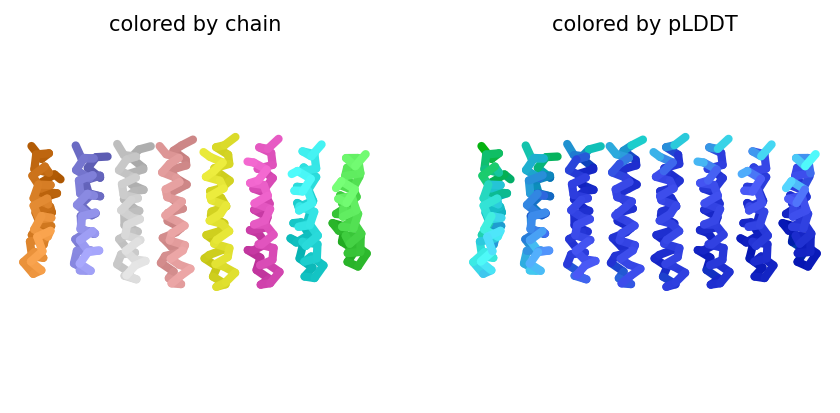

2025-04-02 23:36:08,642 alphafold2_multimer_v2_model_4_seed_003 recycle=0 pLDDT=59.1 pTM=0.226 ipTM=0.125
2025-04-02 23:36:20,813 alphafold2_multimer_v2_model_4_seed_003 recycle=1 pLDDT=58.4 pTM=0.193 ipTM=0.0841 tol=14.5
2025-04-02 23:36:32,991 alphafold2_multimer_v2_model_4_seed_003 recycle=2 pLDDT=57 pTM=0.205 ipTM=0.0995 tol=7.63
2025-04-02 23:36:45,173 alphafold2_multimer_v2_model_4_seed_003 recycle=3 pLDDT=60.2 pTM=0.241 ipTM=0.14 tol=10
2025-04-02 23:36:57,398 alphafold2_multimer_v2_model_4_seed_003 recycle=4 pLDDT=57.8 pTM=0.207 ipTM=0.101 tol=5.66
2025-04-02 23:37:09,572 alphafold2_multimer_v2_model_4_seed_003 recycle=5 pLDDT=69.3 pTM=0.266 ipTM=0.169 tol=7.78
2025-04-02 23:37:21,733 alphafold2_multimer_v2_model_4_seed_003 recycle=6 pLDDT=77.3 pTM=0.274 ipTM=0.177 tol=4.52
2025-04-02 23:37:21,734 alphafold2_multimer_v2_model_4_seed_003 took 85.2s (6 recycles)


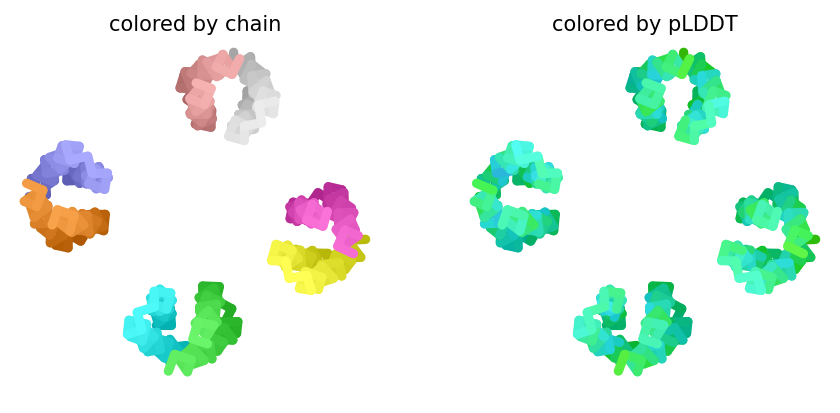

2025-04-02 23:37:34,156 alphafold2_multimer_v2_model_5_seed_003 recycle=0 pLDDT=61.2 pTM=0.274 ipTM=0.178
2025-04-02 23:37:46,330 alphafold2_multimer_v2_model_5_seed_003 recycle=1 pLDDT=56.4 pTM=0.199 ipTM=0.0949 tol=15.7
2025-04-02 23:37:58,540 alphafold2_multimer_v2_model_5_seed_003 recycle=2 pLDDT=60.3 pTM=0.189 ipTM=0.0811 tol=20.3
2025-04-02 23:38:10,714 alphafold2_multimer_v2_model_5_seed_003 recycle=3 pLDDT=56.4 pTM=0.205 ipTM=0.0981 tol=26.3
2025-04-02 23:38:22,901 alphafold2_multimer_v2_model_5_seed_003 recycle=4 pLDDT=57.4 pTM=0.199 ipTM=0.0918 tol=9.17
2025-04-02 23:38:35,097 alphafold2_multimer_v2_model_5_seed_003 recycle=5 pLDDT=57.5 pTM=0.208 ipTM=0.102 tol=8.04
2025-04-02 23:38:47,299 alphafold2_multimer_v2_model_5_seed_003 recycle=6 pLDDT=58.5 pTM=0.209 ipTM=0.103 tol=3.88
2025-04-02 23:38:47,300 alphafold2_multimer_v2_model_5_seed_003 took 85.3s (6 recycles)


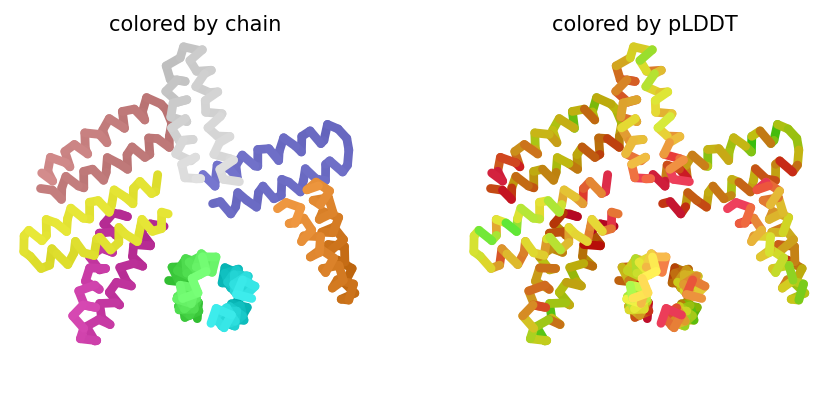

2025-04-02 23:38:59,773 alphafold2_multimer_v2_model_1_seed_004 recycle=0 pLDDT=74.8 pTM=0.295 ipTM=0.201
2025-04-02 23:39:11,920 alphafold2_multimer_v2_model_1_seed_004 recycle=1 pLDDT=74.2 pTM=0.312 ipTM=0.22 tol=17.4
2025-04-02 23:39:24,067 alphafold2_multimer_v2_model_1_seed_004 recycle=2 pLDDT=74.4 pTM=0.34 ipTM=0.251 tol=7.64
2025-04-02 23:39:36,215 alphafold2_multimer_v2_model_1_seed_004 recycle=3 pLDDT=72.2 pTM=0.343 ipTM=0.255 tol=4.07
2025-04-02 23:39:48,364 alphafold2_multimer_v2_model_1_seed_004 recycle=4 pLDDT=71.2 pTM=0.307 ipTM=0.214 tol=4.7
2025-04-02 23:40:00,512 alphafold2_multimer_v2_model_1_seed_004 recycle=5 pLDDT=73.8 pTM=0.362 ipTM=0.277 tol=5.85
2025-04-02 23:40:12,663 alphafold2_multimer_v2_model_1_seed_004 recycle=6 pLDDT=70.6 pTM=0.331 ipTM=0.242 tol=4.5
2025-04-02 23:40:12,664 alphafold2_multimer_v2_model_1_seed_004 took 85.0s (6 recycles)


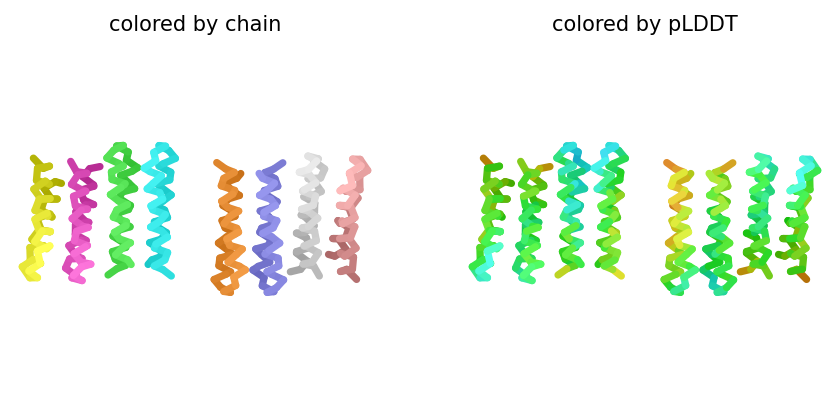

2025-04-02 23:40:25,156 alphafold2_multimer_v2_model_2_seed_004 recycle=0 pLDDT=68.6 pTM=0.289 ipTM=0.197
2025-04-02 23:40:37,328 alphafold2_multimer_v2_model_2_seed_004 recycle=1 pLDDT=71.6 pTM=0.309 ipTM=0.217 tol=9.26
2025-04-02 23:40:49,526 alphafold2_multimer_v2_model_2_seed_004 recycle=2 pLDDT=70.5 pTM=0.323 ipTM=0.234 tol=10
2025-04-02 23:41:01,761 alphafold2_multimer_v2_model_2_seed_004 recycle=3 pLDDT=73.8 pTM=0.33 ipTM=0.242 tol=9.73
2025-04-02 23:41:14,056 alphafold2_multimer_v2_model_2_seed_004 recycle=4 pLDDT=72.4 pTM=0.33 ipTM=0.241 tol=7.24
2025-04-02 23:41:26,388 alphafold2_multimer_v2_model_2_seed_004 recycle=5 pLDDT=72.1 pTM=0.328 ipTM=0.239 tol=9.67
2025-04-02 23:41:38,682 alphafold2_multimer_v2_model_2_seed_004 recycle=6 pLDDT=75.4 pTM=0.326 ipTM=0.236 tol=3.14
2025-04-02 23:41:38,683 alphafold2_multimer_v2_model_2_seed_004 took 85.7s (6 recycles)


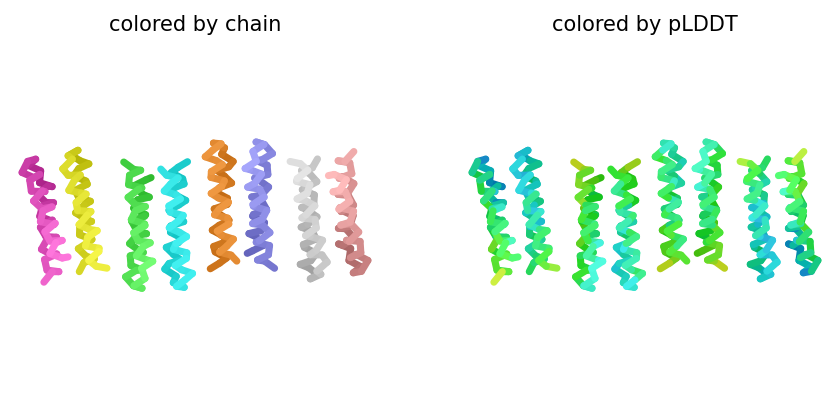

2025-04-02 23:41:51,369 alphafold2_multimer_v2_model_3_seed_004 recycle=0 pLDDT=82.9 pTM=0.629 ipTM=0.583
2025-04-02 23:42:03,588 alphafold2_multimer_v2_model_3_seed_004 recycle=1 pLDDT=92.4 pTM=0.847 ipTM=0.83 tol=5.5
2025-04-02 23:42:15,810 alphafold2_multimer_v2_model_3_seed_004 recycle=2 pLDDT=90.5 pTM=0.782 ipTM=0.756 tol=0.25
2025-04-02 23:42:27,987 alphafold2_multimer_v2_model_3_seed_004 recycle=3 pLDDT=90.3 pTM=0.775 ipTM=0.749 tol=0.166
2025-04-02 23:42:40,149 alphafold2_multimer_v2_model_3_seed_004 recycle=4 pLDDT=90.1 pTM=0.772 ipTM=0.744 tol=0.0505
2025-04-02 23:42:52,314 alphafold2_multimer_v2_model_3_seed_004 recycle=5 pLDDT=88.7 pTM=0.747 ipTM=0.716 tol=0.0857
2025-04-02 23:43:04,476 alphafold2_multimer_v2_model_3_seed_004 recycle=6 pLDDT=92.7 pTM=0.834 ipTM=0.815 tol=1.74
2025-04-02 23:43:04,476 alphafold2_multimer_v2_model_3_seed_004 took 85.4s (6 recycles)


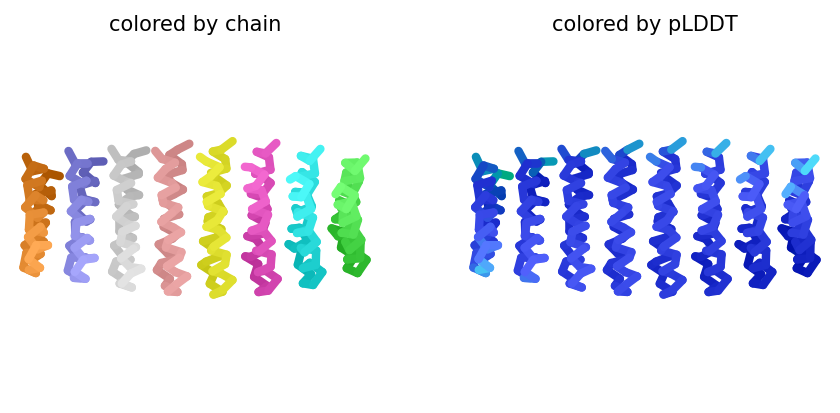

2025-04-02 23:43:16,970 alphafold2_multimer_v2_model_4_seed_004 recycle=0 pLDDT=58.7 pTM=0.215 ipTM=0.112
2025-04-02 23:43:29,168 alphafold2_multimer_v2_model_4_seed_004 recycle=1 pLDDT=56.8 pTM=0.196 ipTM=0.0881 tol=14.6
2025-04-02 23:43:41,325 alphafold2_multimer_v2_model_4_seed_004 recycle=2 pLDDT=57.9 pTM=0.197 ipTM=0.0901 tol=8.63
2025-04-02 23:43:53,480 alphafold2_multimer_v2_model_4_seed_004 recycle=3 pLDDT=57 pTM=0.203 ipTM=0.0967 tol=6.74
2025-04-02 23:44:05,626 alphafold2_multimer_v2_model_4_seed_004 recycle=4 pLDDT=73.4 pTM=0.282 ipTM=0.186 tol=3.24
2025-04-02 23:44:17,804 alphafold2_multimer_v2_model_4_seed_004 recycle=5 pLDDT=78.5 pTM=0.284 ipTM=0.188 tol=2.43
2025-04-02 23:44:30,000 alphafold2_multimer_v2_model_4_seed_004 recycle=6 pLDDT=78.6 pTM=0.28 ipTM=0.184 tol=1.16
2025-04-02 23:44:30,001 alphafold2_multimer_v2_model_4_seed_004 took 85.2s (6 recycles)


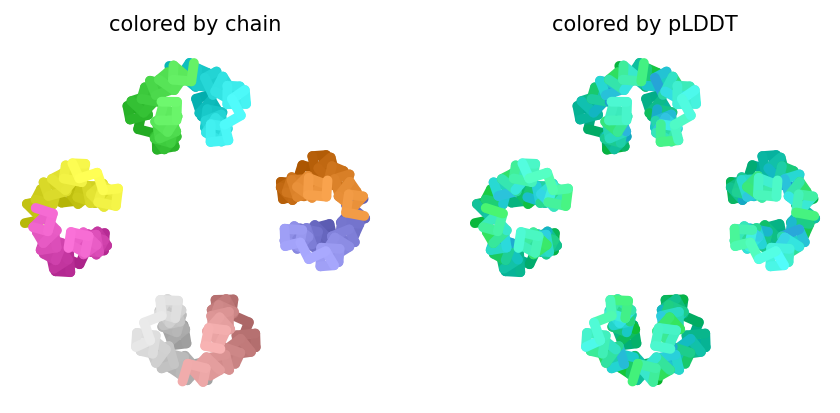

2025-04-02 23:44:42,650 alphafold2_multimer_v2_model_5_seed_004 recycle=0 pLDDT=60.4 pTM=0.249 ipTM=0.15
2025-04-02 23:44:54,873 alphafold2_multimer_v2_model_5_seed_004 recycle=1 pLDDT=58 pTM=0.199 ipTM=0.0927 tol=11.2
2025-04-02 23:45:07,077 alphafold2_multimer_v2_model_5_seed_004 recycle=2 pLDDT=58.3 pTM=0.2 ipTM=0.0925 tol=8.69
2025-04-02 23:45:19,250 alphafold2_multimer_v2_model_5_seed_004 recycle=3 pLDDT=56.6 pTM=0.203 ipTM=0.0969 tol=8.3
2025-04-02 23:45:31,434 alphafold2_multimer_v2_model_5_seed_004 recycle=4 pLDDT=57 pTM=0.201 ipTM=0.095 tol=7.41
2025-04-02 23:45:43,602 alphafold2_multimer_v2_model_5_seed_004 recycle=5 pLDDT=56.5 pTM=0.207 ipTM=0.101 tol=10.5
2025-04-02 23:45:55,781 alphafold2_multimer_v2_model_5_seed_004 recycle=6 pLDDT=57.9 pTM=0.204 ipTM=0.0997 tol=5.19
2025-04-02 23:45:55,781 alphafold2_multimer_v2_model_5_seed_004 took 85.5s (6 recycles)


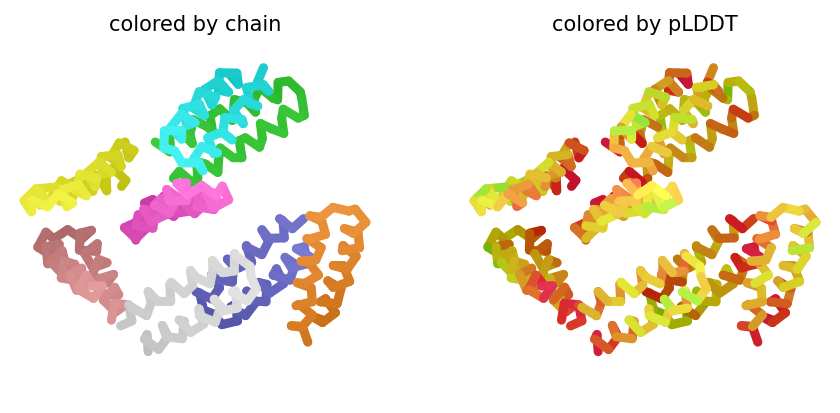

2025-04-02 23:46:08,277 alphafold2_multimer_v2_model_1_seed_005 recycle=0 pLDDT=74.3 pTM=0.301 ipTM=0.207
2025-04-02 23:46:20,444 alphafold2_multimer_v2_model_1_seed_005 recycle=1 pLDDT=74.2 pTM=0.312 ipTM=0.22 tol=17.2
2025-04-02 23:46:32,633 alphafold2_multimer_v2_model_1_seed_005 recycle=2 pLDDT=75.4 pTM=0.341 ipTM=0.253 tol=6.99
2025-04-02 23:46:44,779 alphafold2_multimer_v2_model_1_seed_005 recycle=3 pLDDT=75.4 pTM=0.416 ipTM=0.338 tol=9.09
2025-04-02 23:46:56,946 alphafold2_multimer_v2_model_1_seed_005 recycle=4 pLDDT=77.1 pTM=0.389 ipTM=0.308 tol=8.18
2025-04-02 23:47:09,086 alphafold2_multimer_v2_model_1_seed_005 recycle=5 pLDDT=80.2 pTM=0.48 ipTM=0.412 tol=4.03
2025-04-02 23:47:21,240 alphafold2_multimer_v2_model_1_seed_005 recycle=6 pLDDT=82.9 pTM=0.5 ipTM=0.434 tol=0.169
2025-04-02 23:47:21,241 alphafold2_multimer_v2_model_1_seed_005 took 85.1s (6 recycles)


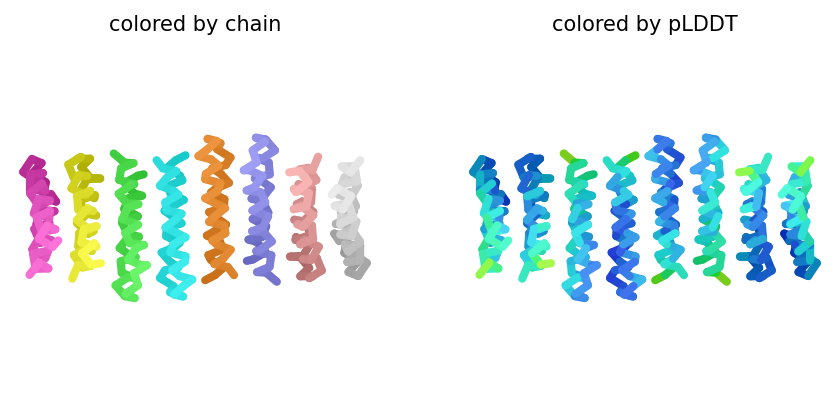

2025-04-02 23:47:33,758 alphafold2_multimer_v2_model_2_seed_005 recycle=0 pLDDT=57.9 pTM=0.262 ipTM=0.167
2025-04-02 23:47:45,937 alphafold2_multimer_v2_model_2_seed_005 recycle=1 pLDDT=56.3 pTM=0.235 ipTM=0.135 tol=21.6
2025-04-02 23:47:58,103 alphafold2_multimer_v2_model_2_seed_005 recycle=2 pLDDT=54.6 pTM=0.197 ipTM=0.0934 tol=8.26
2025-04-02 23:48:10,286 alphafold2_multimer_v2_model_2_seed_005 recycle=3 pLDDT=54.9 pTM=0.199 ipTM=0.0923 tol=10.5
2025-04-02 23:48:22,459 alphafold2_multimer_v2_model_2_seed_005 recycle=4 pLDDT=54.8 pTM=0.204 ipTM=0.0995 tol=14.3
2025-04-02 23:48:34,635 alphafold2_multimer_v2_model_2_seed_005 recycle=5 pLDDT=54.1 pTM=0.2 ipTM=0.0972 tol=9.71
2025-04-02 23:48:46,816 alphafold2_multimer_v2_model_2_seed_005 recycle=6 pLDDT=55.2 pTM=0.205 ipTM=0.1 tol=9.16
2025-04-02 23:48:46,816 alphafold2_multimer_v2_model_2_seed_005 took 85.3s (6 recycles)


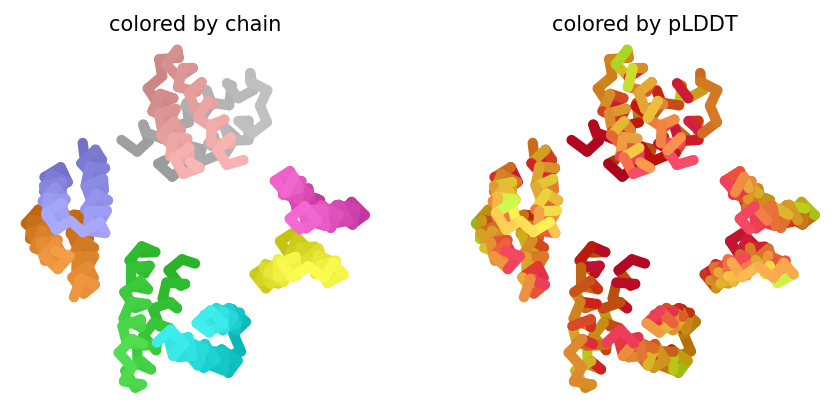

2025-04-02 23:48:59,285 alphafold2_multimer_v2_model_3_seed_005 recycle=0 pLDDT=93.4 pTM=0.843 ipTM=0.826
2025-04-02 23:49:11,443 alphafold2_multimer_v2_model_3_seed_005 recycle=1 pLDDT=88.8 pTM=0.778 ipTM=0.75 tol=1.75
2025-04-02 23:49:23,602 alphafold2_multimer_v2_model_3_seed_005 recycle=2 pLDDT=93.6 pTM=0.841 ipTM=0.823 tol=0.312
2025-04-02 23:49:35,767 alphafold2_multimer_v2_model_3_seed_005 recycle=3 pLDDT=93.4 pTM=0.833 ipTM=0.813 tol=0.0805
2025-04-02 23:49:47,906 alphafold2_multimer_v2_model_3_seed_005 recycle=4 pLDDT=92.8 pTM=0.816 ipTM=0.794 tol=0.0569
2025-04-02 23:50:00,044 alphafold2_multimer_v2_model_3_seed_005 recycle=5 pLDDT=92.4 pTM=0.808 ipTM=0.785 tol=0.0503
2025-04-02 23:50:12,176 alphafold2_multimer_v2_model_3_seed_005 recycle=6 pLDDT=92.2 pTM=0.801 ipTM=0.777 tol=0.028
2025-04-02 23:50:12,177 alphafold2_multimer_v2_model_3_seed_005 took 85.1s (6 recycles)


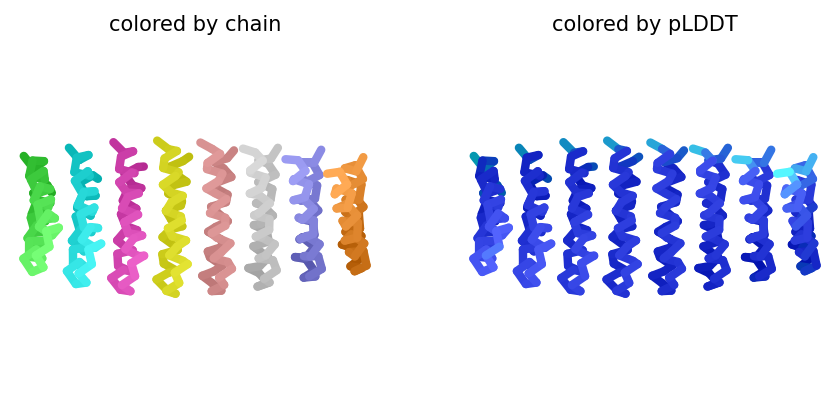

2025-04-02 23:50:24,675 alphafold2_multimer_v2_model_4_seed_005 recycle=0 pLDDT=58.7 pTM=0.228 ipTM=0.126
2025-04-02 23:50:36,874 alphafold2_multimer_v2_model_4_seed_005 recycle=1 pLDDT=57.5 pTM=0.188 ipTM=0.0798 tol=14.1
2025-04-02 23:50:49,064 alphafold2_multimer_v2_model_4_seed_005 recycle=2 pLDDT=56.7 pTM=0.203 ipTM=0.0962 tol=8.47
2025-04-02 23:51:01,270 alphafold2_multimer_v2_model_4_seed_005 recycle=3 pLDDT=64.5 pTM=0.271 ipTM=0.174 tol=13.6
2025-04-02 23:51:13,458 alphafold2_multimer_v2_model_4_seed_005 recycle=4 pLDDT=67.2 pTM=0.264 ipTM=0.166 tol=4.9
2025-04-02 23:51:25,661 alphafold2_multimer_v2_model_4_seed_005 recycle=5 pLDDT=59.8 pTM=0.229 ipTM=0.126 tol=1.33
2025-04-02 23:51:37,857 alphafold2_multimer_v2_model_4_seed_005 recycle=6 pLDDT=59.1 pTM=0.214 ipTM=0.109 tol=2.7
2025-04-02 23:51:37,857 alphafold2_multimer_v2_model_4_seed_005 took 85.3s (6 recycles)


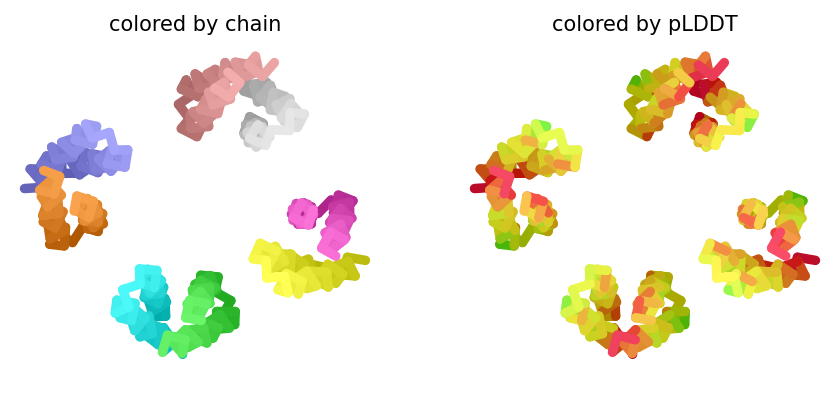

2025-04-02 23:51:50,318 alphafold2_multimer_v2_model_5_seed_005 recycle=0 pLDDT=58.7 pTM=0.236 ipTM=0.136
2025-04-02 23:52:02,493 alphafold2_multimer_v2_model_5_seed_005 recycle=1 pLDDT=58.4 pTM=0.196 ipTM=0.0886 tol=17
2025-04-02 23:52:14,646 alphafold2_multimer_v2_model_5_seed_005 recycle=2 pLDDT=57.2 pTM=0.203 ipTM=0.0963 tol=8.81
2025-04-02 23:52:26,831 alphafold2_multimer_v2_model_5_seed_005 recycle=3 pLDDT=58.8 pTM=0.204 ipTM=0.0962 tol=4.12
2025-04-02 23:52:39,000 alphafold2_multimer_v2_model_5_seed_005 recycle=4 pLDDT=56.4 pTM=0.201 ipTM=0.0949 tol=6.13
2025-04-02 23:52:51,150 alphafold2_multimer_v2_model_5_seed_005 recycle=5 pLDDT=57.8 pTM=0.213 ipTM=0.108 tol=6.27
2025-04-02 23:53:03,307 alphafold2_multimer_v2_model_5_seed_005 recycle=6 pLDDT=57.7 pTM=0.197 ipTM=0.0899 tol=6.11
2025-04-02 23:53:03,308 alphafold2_multimer_v2_model_5_seed_005 took 85.1s (6 recycles)


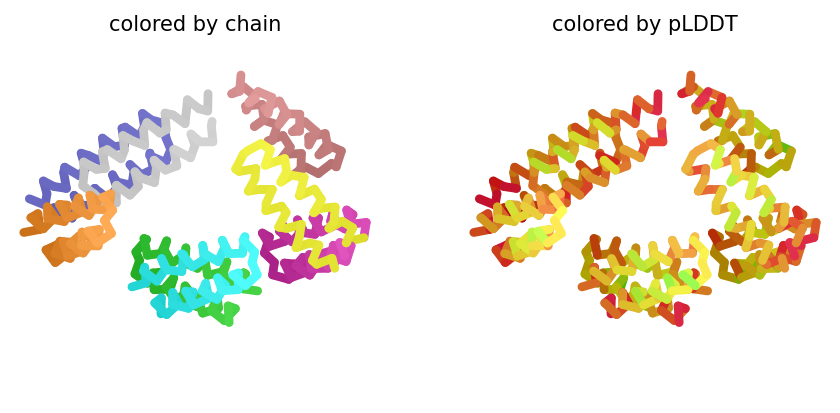

2025-04-02 23:53:15,782 alphafold2_multimer_v2_model_1_seed_006 recycle=0 pLDDT=74.3 pTM=0.293 ipTM=0.199
2025-04-02 23:53:27,911 alphafold2_multimer_v2_model_1_seed_006 recycle=1 pLDDT=74.1 pTM=0.298 ipTM=0.204 tol=15.4
2025-04-02 23:53:40,061 alphafold2_multimer_v2_model_1_seed_006 recycle=2 pLDDT=75.8 pTM=0.306 ipTM=0.212 tol=20.6
2025-04-02 23:53:52,208 alphafold2_multimer_v2_model_1_seed_006 recycle=3 pLDDT=78.9 pTM=0.426 ipTM=0.35 tol=10.1
2025-04-02 23:54:04,353 alphafold2_multimer_v2_model_1_seed_006 recycle=4 pLDDT=74.8 pTM=0.323 ipTM=0.232 tol=8.41
2025-04-02 23:54:16,503 alphafold2_multimer_v2_model_1_seed_006 recycle=5 pLDDT=72.6 pTM=0.324 ipTM=0.233 tol=10.1
2025-04-02 23:54:28,638 alphafold2_multimer_v2_model_1_seed_006 recycle=6 pLDDT=75.1 pTM=0.364 ipTM=0.279 tol=25.9
2025-04-02 23:54:28,639 alphafold2_multimer_v2_model_1_seed_006 took 85.0s (6 recycles)


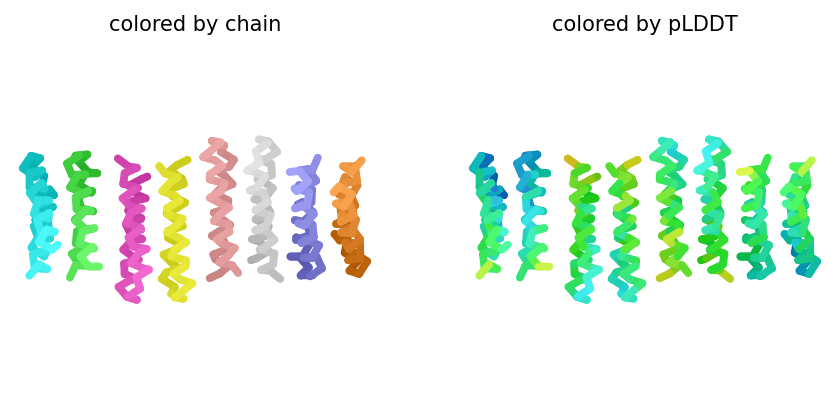

2025-04-02 23:54:41,128 alphafold2_multimer_v2_model_2_seed_006 recycle=0 pLDDT=69.2 pTM=0.284 ipTM=0.19
2025-04-02 23:54:53,286 alphafold2_multimer_v2_model_2_seed_006 recycle=1 pLDDT=69.8 pTM=0.292 ipTM=0.199 tol=20.5
2025-04-02 23:55:05,444 alphafold2_multimer_v2_model_2_seed_006 recycle=2 pLDDT=71.1 pTM=0.303 ipTM=0.213 tol=12.8
2025-04-02 23:55:17,640 alphafold2_multimer_v2_model_2_seed_006 recycle=3 pLDDT=73.4 pTM=0.321 ipTM=0.232 tol=20
2025-04-02 23:55:29,790 alphafold2_multimer_v2_model_2_seed_006 recycle=4 pLDDT=70.5 pTM=0.295 ipTM=0.201 tol=15.3
2025-04-02 23:55:41,980 alphafold2_multimer_v2_model_2_seed_006 recycle=5 pLDDT=68.6 pTM=0.287 ipTM=0.191 tol=10.8
2025-04-02 23:55:54,149 alphafold2_multimer_v2_model_2_seed_006 recycle=6 pLDDT=69.3 pTM=0.274 ipTM=0.176 tol=27.8
2025-04-02 23:55:54,150 alphafold2_multimer_v2_model_2_seed_006 took 85.2s (6 recycles)


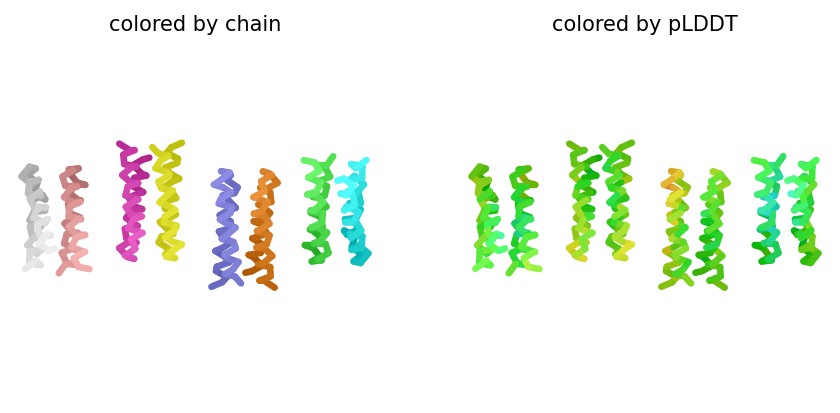

2025-04-02 23:56:06,638 alphafold2_multimer_v2_model_3_seed_006 recycle=0 pLDDT=87.5 pTM=0.62 ipTM=0.572
2025-04-02 23:56:18,792 alphafold2_multimer_v2_model_3_seed_006 recycle=1 pLDDT=86.1 pTM=0.587 ipTM=0.535 tol=2.17
2025-04-02 23:56:30,937 alphafold2_multimer_v2_model_3_seed_006 recycle=2 pLDDT=84.8 pTM=0.619 ipTM=0.571 tol=2.72
2025-04-02 23:56:43,089 alphafold2_multimer_v2_model_3_seed_006 recycle=3 pLDDT=83.6 pTM=0.572 ipTM=0.518 tol=0.572
2025-04-02 23:56:55,214 alphafold2_multimer_v2_model_3_seed_006 recycle=4 pLDDT=84.2 pTM=0.609 ipTM=0.559 tol=0.761
2025-04-02 23:57:07,354 alphafold2_multimer_v2_model_3_seed_006 recycle=5 pLDDT=84.7 pTM=0.617 ipTM=0.569 tol=0.352
2025-04-02 23:57:19,487 alphafold2_multimer_v2_model_3_seed_006 recycle=6 pLDDT=86.4 pTM=0.665 ipTM=0.622 tol=0.746
2025-04-02 23:57:19,487 alphafold2_multimer_v2_model_3_seed_006 took 85.0s (6 recycles)


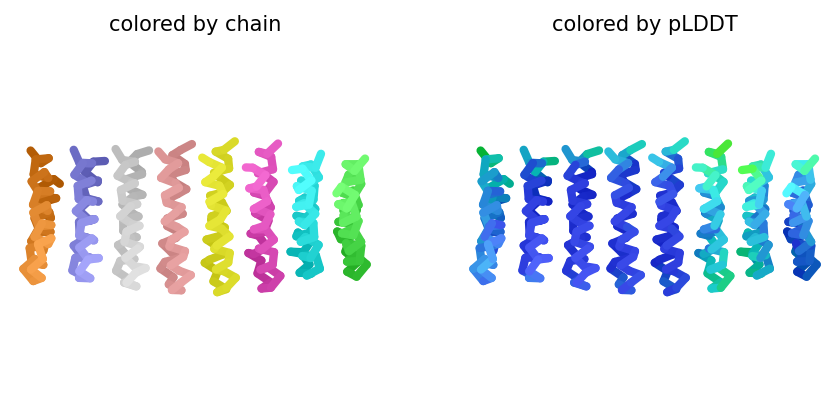

2025-04-02 23:57:31,966 alphafold2_multimer_v2_model_4_seed_006 recycle=0 pLDDT=59.3 pTM=0.23 ipTM=0.129
2025-04-02 23:57:44,177 alphafold2_multimer_v2_model_4_seed_006 recycle=1 pLDDT=57.5 pTM=0.187 ipTM=0.0785 tol=16.8
2025-04-02 23:57:56,347 alphafold2_multimer_v2_model_4_seed_006 recycle=2 pLDDT=57.3 pTM=0.195 ipTM=0.0873 tol=12.5
2025-04-02 23:58:08,512 alphafold2_multimer_v2_model_4_seed_006 recycle=3 pLDDT=76.4 pTM=0.294 ipTM=0.199 tol=13.2
2025-04-02 23:58:20,723 alphafold2_multimer_v2_model_4_seed_006 recycle=4 pLDDT=78.7 pTM=0.279 ipTM=0.183 tol=3.41
2025-04-02 23:58:32,919 alphafold2_multimer_v2_model_4_seed_006 recycle=5 pLDDT=78.6 pTM=0.282 ipTM=0.185 tol=1.79
2025-04-02 23:58:45,103 alphafold2_multimer_v2_model_4_seed_006 recycle=6 pLDDT=79 pTM=0.279 ipTM=0.182 tol=2.3
2025-04-02 23:58:45,104 alphafold2_multimer_v2_model_4_seed_006 took 85.3s (6 recycles)


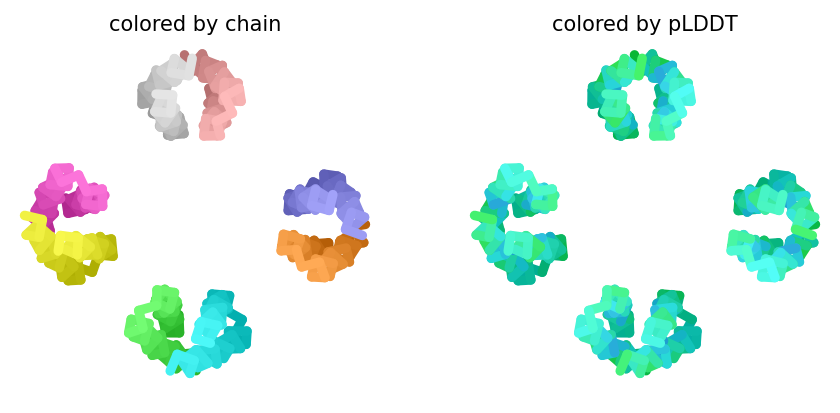

2025-04-02 23:58:57,624 alphafold2_multimer_v2_model_5_seed_006 recycle=0 pLDDT=59.2 pTM=0.214 ipTM=0.11
2025-04-02 23:59:09,808 alphafold2_multimer_v2_model_5_seed_006 recycle=1 pLDDT=56 pTM=0.201 ipTM=0.0948 tol=21.8
2025-04-02 23:59:21,973 alphafold2_multimer_v2_model_5_seed_006 recycle=2 pLDDT=56.2 pTM=0.202 ipTM=0.0955 tol=17.2
2025-04-02 23:59:34,125 alphafold2_multimer_v2_model_5_seed_006 recycle=3 pLDDT=56.5 pTM=0.207 ipTM=0.103 tol=18.4
2025-04-02 23:59:46,292 alphafold2_multimer_v2_model_5_seed_006 recycle=4 pLDDT=56.9 pTM=0.206 ipTM=0.1 tol=13.9
2025-04-02 23:59:58,459 alphafold2_multimer_v2_model_5_seed_006 recycle=5 pLDDT=55.2 pTM=0.202 ipTM=0.0955 tol=10.2
2025-04-03 00:00:10,626 alphafold2_multimer_v2_model_5_seed_006 recycle=6 pLDDT=56.9 pTM=0.206 ipTM=0.0983 tol=10.5
2025-04-03 00:00:10,627 alphafold2_multimer_v2_model_5_seed_006 took 85.2s (6 recycles)


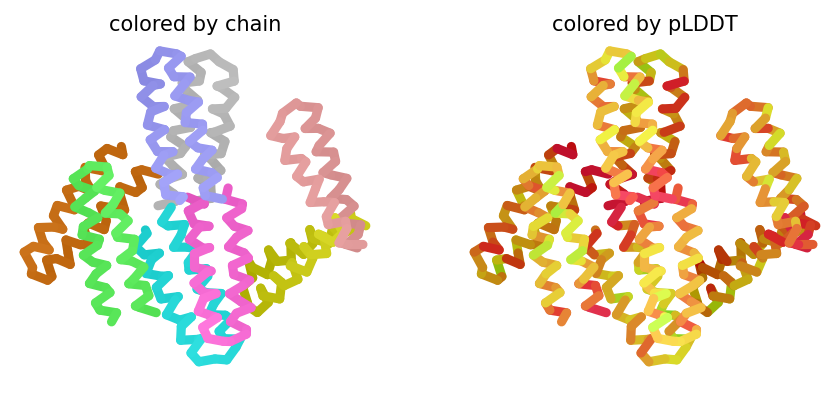

2025-04-03 00:00:23,192 alphafold2_multimer_v2_model_1_seed_007 recycle=0 pLDDT=74.6 pTM=0.299 ipTM=0.206
2025-04-03 00:00:35,415 alphafold2_multimer_v2_model_1_seed_007 recycle=1 pLDDT=74.9 pTM=0.314 ipTM=0.223 tol=13.7
2025-04-03 00:00:47,651 alphafold2_multimer_v2_model_1_seed_007 recycle=2 pLDDT=75.6 pTM=0.39 ipTM=0.308 tol=7.73
2025-04-03 00:00:59,932 alphafold2_multimer_v2_model_1_seed_007 recycle=3 pLDDT=75.8 pTM=0.38 ipTM=0.299 tol=3.15
2025-04-03 00:01:12,186 alphafold2_multimer_v2_model_1_seed_007 recycle=4 pLDDT=76.1 pTM=0.349 ipTM=0.262 tol=3.32
2025-04-03 00:01:24,449 alphafold2_multimer_v2_model_1_seed_007 recycle=5 pLDDT=74.1 pTM=0.35 ipTM=0.262 tol=0.856
2025-04-03 00:01:36,691 alphafold2_multimer_v2_model_1_seed_007 recycle=6 pLDDT=76.2 pTM=0.422 ipTM=0.345 tol=16.3
2025-04-03 00:01:36,692 alphafold2_multimer_v2_model_1_seed_007 took 85.7s (6 recycles)


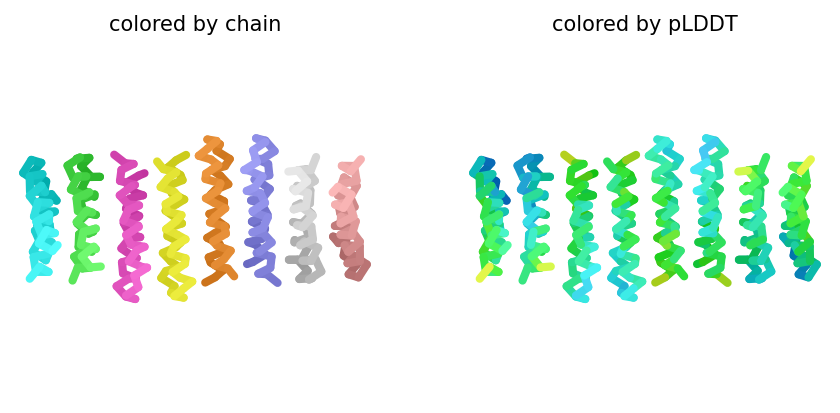

2025-04-03 00:01:49,435 alphafold2_multimer_v2_model_2_seed_007 recycle=0 pLDDT=60.2 pTM=0.261 ipTM=0.166
2025-04-03 00:02:01,607 alphafold2_multimer_v2_model_2_seed_007 recycle=1 pLDDT=58.3 pTM=0.241 ipTM=0.142 tol=10.9
2025-04-03 00:02:13,870 alphafold2_multimer_v2_model_2_seed_007 recycle=2 pLDDT=53.3 pTM=0.203 ipTM=0.0985 tol=13.3
2025-04-03 00:02:26,148 alphafold2_multimer_v2_model_2_seed_007 recycle=3 pLDDT=54.5 pTM=0.201 ipTM=0.0963 tol=11.2
2025-04-03 00:02:38,329 alphafold2_multimer_v2_model_2_seed_007 recycle=4 pLDDT=54.2 pTM=0.206 ipTM=0.102 tol=10.7
2025-04-03 00:02:50,492 alphafold2_multimer_v2_model_2_seed_007 recycle=5 pLDDT=54.9 pTM=0.201 ipTM=0.0956 tol=8.01
2025-04-03 00:03:02,662 alphafold2_multimer_v2_model_2_seed_007 recycle=6 pLDDT=54.6 pTM=0.201 ipTM=0.097 tol=6.8
2025-04-03 00:03:02,663 alphafold2_multimer_v2_model_2_seed_007 took 85.5s (6 recycles)


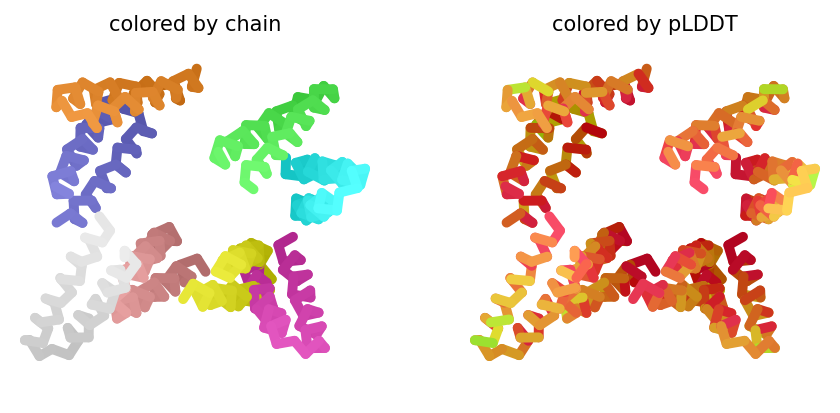

2025-04-03 00:03:15,112 alphafold2_multimer_v2_model_3_seed_007 recycle=0 pLDDT=85.2 pTM=0.629 ipTM=0.583
2025-04-03 00:03:27,242 alphafold2_multimer_v2_model_3_seed_007 recycle=1 pLDDT=84.9 pTM=0.667 ipTM=0.626 tol=3.35
2025-04-03 00:03:39,338 alphafold2_multimer_v2_model_3_seed_007 recycle=2 pLDDT=89.4 pTM=0.758 ipTM=0.728 tol=1.21
2025-04-03 00:03:51,451 alphafold2_multimer_v2_model_3_seed_007 recycle=3 pLDDT=85.4 pTM=0.642 ipTM=0.597 tol=0.687
2025-04-03 00:04:03,578 alphafold2_multimer_v2_model_3_seed_007 recycle=4 pLDDT=87.9 pTM=0.698 ipTM=0.66 tol=0.598
2025-04-03 00:04:15,740 alphafold2_multimer_v2_model_3_seed_007 recycle=5 pLDDT=85.6 pTM=0.645 ipTM=0.601 tol=0.561
2025-04-03 00:04:27,895 alphafold2_multimer_v2_model_3_seed_007 recycle=6 pLDDT=88 pTM=0.697 ipTM=0.659 tol=0.59
2025-04-03 00:04:27,897 alphafold2_multimer_v2_model_3_seed_007 took 84.9s (6 recycles)


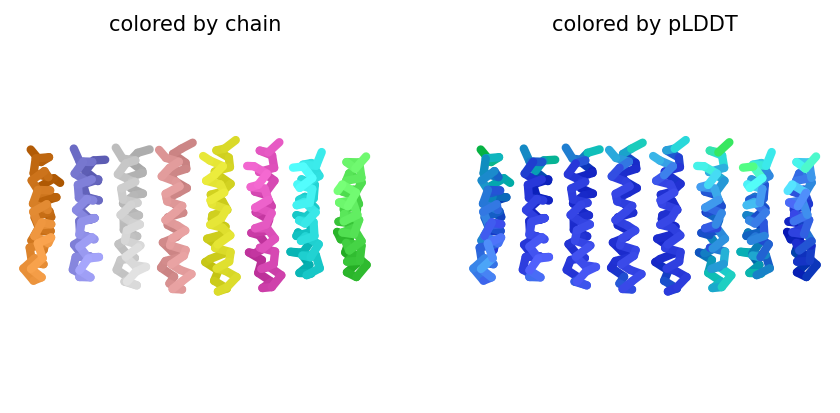

2025-04-03 00:04:40,455 alphafold2_multimer_v2_model_4_seed_007 recycle=0 pLDDT=57.3 pTM=0.201 ipTM=0.0956
2025-04-03 00:04:52,713 alphafold2_multimer_v2_model_4_seed_007 recycle=1 pLDDT=58.6 pTM=0.185 ipTM=0.076 tol=13.9
2025-04-03 00:05:04,870 alphafold2_multimer_v2_model_4_seed_007 recycle=2 pLDDT=57.4 pTM=0.201 ipTM=0.0942 tol=10
2025-04-03 00:05:17,023 alphafold2_multimer_v2_model_4_seed_007 recycle=3 pLDDT=64.6 pTM=0.269 ipTM=0.171 tol=5.98
2025-04-03 00:05:29,163 alphafold2_multimer_v2_model_4_seed_007 recycle=4 pLDDT=66.2 pTM=0.266 ipTM=0.168 tol=3.51
2025-04-03 00:05:41,320 alphafold2_multimer_v2_model_4_seed_007 recycle=5 pLDDT=58.9 pTM=0.219 ipTM=0.114 tol=1.51
2025-04-03 00:05:53,509 alphafold2_multimer_v2_model_4_seed_007 recycle=6 pLDDT=57.4 pTM=0.207 ipTM=0.102 tol=2.18
2025-04-03 00:05:53,510 alphafold2_multimer_v2_model_4_seed_007 took 85.3s (6 recycles)


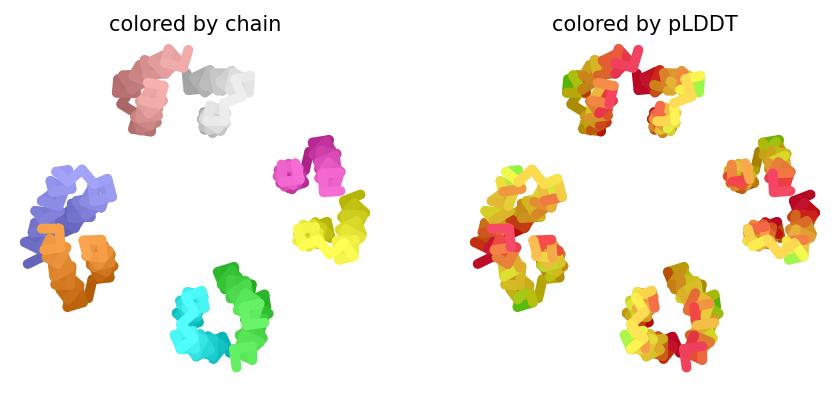

2025-04-03 00:06:05,999 alphafold2_multimer_v2_model_5_seed_007 recycle=0 pLDDT=57.9 pTM=0.24 ipTM=0.142
2025-04-03 00:06:18,209 alphafold2_multimer_v2_model_5_seed_007 recycle=1 pLDDT=55.9 pTM=0.198 ipTM=0.0906 tol=17
2025-04-03 00:06:30,418 alphafold2_multimer_v2_model_5_seed_007 recycle=2 pLDDT=59.1 pTM=0.199 ipTM=0.0933 tol=14.3
2025-04-03 00:06:42,607 alphafold2_multimer_v2_model_5_seed_007 recycle=3 pLDDT=57.4 pTM=0.209 ipTM=0.103 tol=8.67
2025-04-03 00:06:54,802 alphafold2_multimer_v2_model_5_seed_007 recycle=4 pLDDT=58.3 pTM=0.208 ipTM=0.102 tol=3.99
2025-04-03 00:07:06,978 alphafold2_multimer_v2_model_5_seed_007 recycle=5 pLDDT=57 pTM=0.211 ipTM=0.106 tol=5.98
2025-04-03 00:07:19,169 alphafold2_multimer_v2_model_5_seed_007 recycle=6 pLDDT=59.4 pTM=0.206 ipTM=0.1 tol=5.48
2025-04-03 00:07:19,170 alphafold2_multimer_v2_model_5_seed_007 took 85.3s (6 recycles)


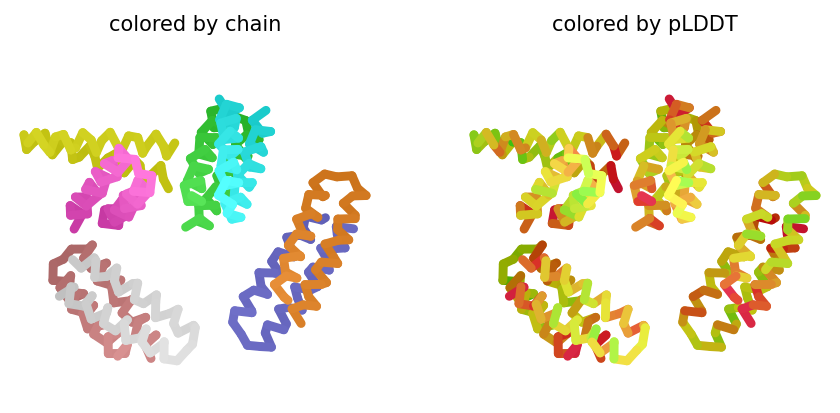

2025-04-03 00:07:19,510 reranking models by 'multimer' metric
2025-04-03 00:07:19,511 rank_001_alphafold2_multimer_v2_model_3_seed_004 pLDDT=92.7 pTM=0.834 ipTM=0.815
2025-04-03 00:07:19,511 rank_002_alphafold2_multimer_v2_model_3_seed_001 pLDDT=92.5 pTM=0.813 ipTM=0.791
2025-04-03 00:07:19,511 rank_003_alphafold2_multimer_v2_model_3_seed_002 pLDDT=91.8 pTM=0.812 ipTM=0.79
2025-04-03 00:07:19,511 rank_004_alphafold2_multimer_v2_model_3_seed_000 pLDDT=92.5 pTM=0.812 ipTM=0.79
2025-04-03 00:07:19,512 rank_005_alphafold2_multimer_v2_model_3_seed_005 pLDDT=92.2 pTM=0.801 ipTM=0.777
2025-04-03 00:07:19,512 rank_006_alphafold2_multimer_v2_model_3_seed_003 pLDDT=88.9 pTM=0.746 ipTM=0.716
2025-04-03 00:07:19,512 rank_007_alphafold2_multimer_v2_model_3_seed_007 pLDDT=88 pTM=0.697 ipTM=0.659
2025-04-03 00:07:19,512 rank_008_alphafold2_multimer_v2_model_3_seed_006 pLDDT=86.4 pTM=0.665 ipTM=0.622
2025-04-03 00:07:19,512 rank_009_alphafold2_multimer_v2_model_1_seed_000 pLDDT=83.4 pTM=0.556 ipTM=0.4

0

In [6]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

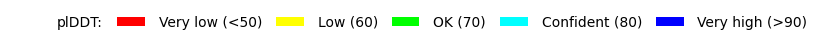

In [7]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


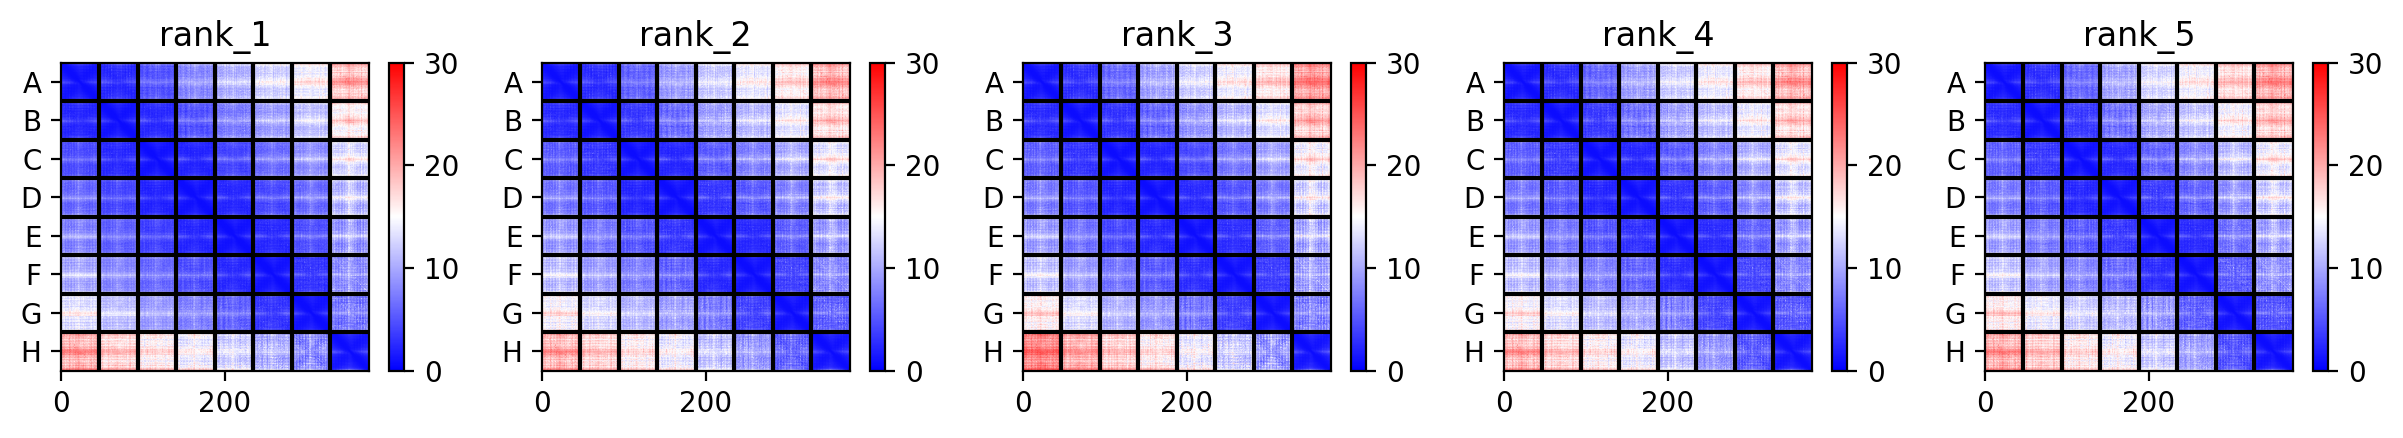
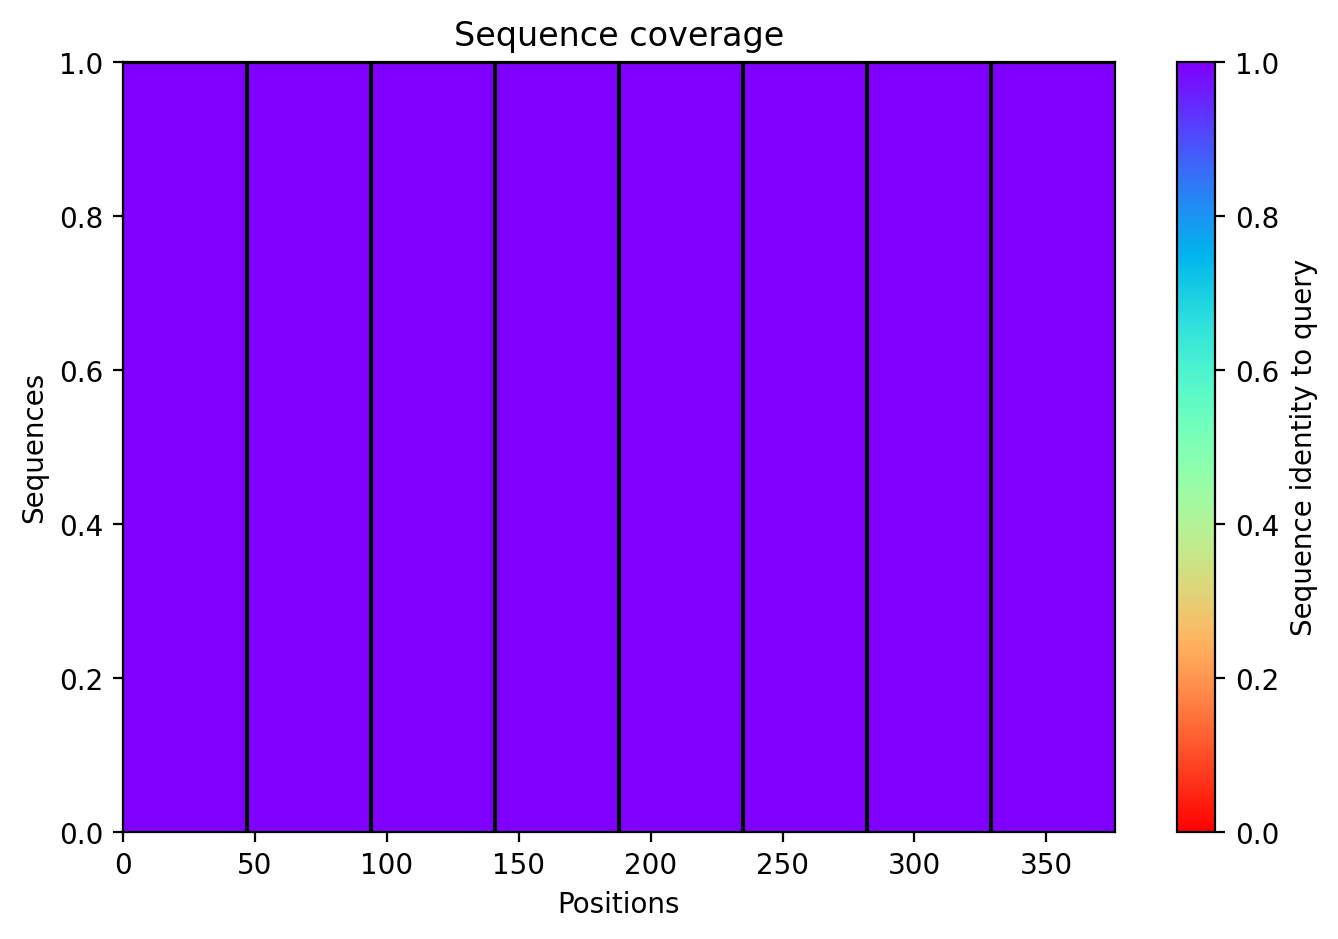
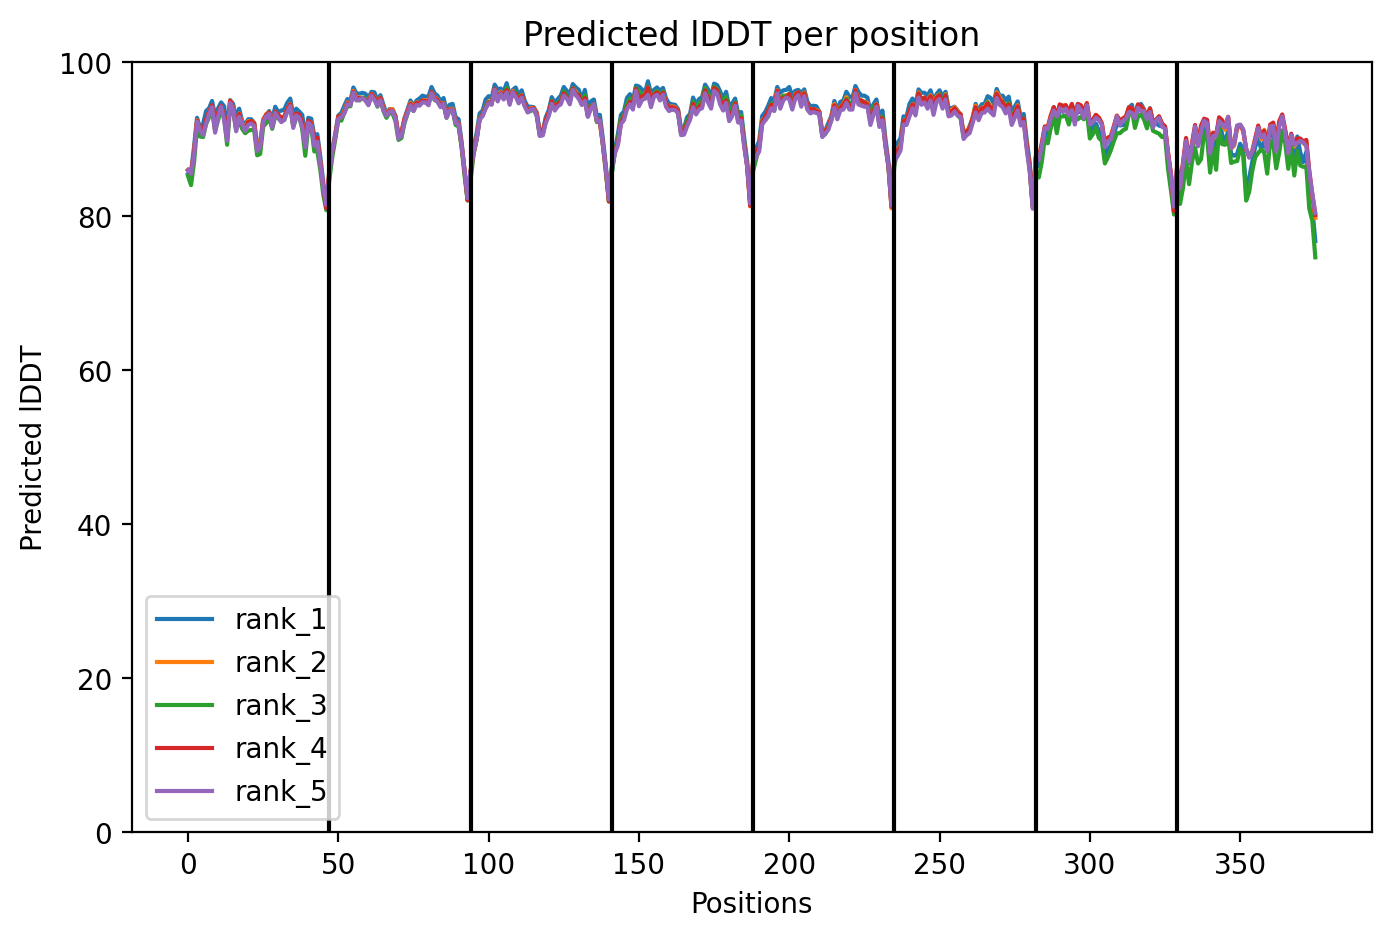

In [8]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [9]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
